In [1]:
import os, pickle, h5py, importlib, itertools, json, copy, warnings, re
from collections import defaultdict
import numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm, trange
from scipy.sparse import coo_matrix
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_rel, chi2, mannwhitneyu, levene
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
from sklearn.neighbors import NearestNeighbors, KernelDensity

import torch
from torch import nn
import torch.nn.functional as F
from algo.Hcformer_pretrain import Hcformer, CNN_Extractor
from utils.data import str_to_seq_indices

import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as mplstyle
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
path2dir = Path('/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC')
path2figdir = Path('/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC')
os.makedirs(path2figdir, exist_ok=True)
path2tmpdir = Path('tmp-gradient')
os.makedirs(path2tmpdir, exist_ok=True)

# Load misc

In [3]:
with open(path2dir / 'color_map_mBC.json', 'r') as f:
    cell_type_color_map = json.load(f)

In [4]:
def load_gene_annotation(keep_type=('gene',)):
    df = pd.read_csv(
        '/work/magroup/tianming/Researches/sc-hic/data/genome/mm10/gencode.vM25.annotation.gtf.gz',
        header=0,
        skiprows=5,
        usecols=[0, 2, 3, 4, 6, 8],
        index_col=False,
        names=['chrom', 'type', 'start', 'end', 'strand', 'annotation'],
        delimiter='\t',
    )
    if keep_type is not None:
        df = df[df['type'].isin(['gene'])]
    pattern = re.compile(r'gene_name "([^"]+)";')
    df['gene_name'] = [pattern.search(_).group(1) for _ in df['annotation']]
    pattern = re.compile(r'gene_type "([^;]+)";')
    df['gene_type'] = [pattern.search(_).group(1) for _ in df['annotation']]
    # pattern = re.compile(r'gene_id "([^"]+)\.\d+";')
    pattern = re.compile(r'gene_id "([^"]+)";')
    df['ID'] = [pattern.search(_).group(1).split('.')[0] for _ in df['annotation']]
    # pattern = re.compile(r'gene_id "([^"]+)";')
    # df['gene_id'] = [pattern.search(_).group(1) for _ in df['annotation']]
    df['gene_id'] = df['ID']
    return df

df_gene_anno = load_gene_annotation()

# Load input & meta data

In [5]:
path2dir = Path('/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC')

feat_1d_list = ['ab', 'is-hw25', 'is-hw50', 'is-hw100', 'genebody']
hic_1d_all = []
for feat_name in tqdm(feat_1d_list):
    with open(path2dir / f'1d-score-celltypebulk-10kb-{feat_name}_1024_200_uint8.pkl', 'rb') as f:
        hic_1d_all.append(pickle.load(f).reshape(28, 3740, 400).astype(float) / 255)
hic_1d_all = np.stack(hic_1d_all, axis=-1)
print('Hi-C 1D', hic_1d_all.shape)

with open(path2dir / 'expression_cov_1024_200_celltypebulk.pkl', 'rb') as f:
    expression_all = pickle.load(f)
expression_all = np.concatenate([_.toarray() for _ in expression_all.ravel()], axis=0).reshape(28, 3740, 400)
expression_all = expression_all.reshape(28, 3740 * 400)
row_min = np.min(expression_all, axis=1, keepdims=True)
row_max = np.max(expression_all, axis=1, keepdims=True)
expression_all = (expression_all - row_min) / (row_max - row_min)
expression_all = np.log1p(expression_all * 1e4)
expression_all = expression_all.reshape(28, 3740, 400)
print('expression', expression_all.shape)

with open(path2dir / 'sequence_1024_200.tsv', 'r') as f:
    sequence_all = np.array(f.read().upper().strip().split())
print('sequence', sequence_all.shape, len(sequence_all[0]))

df_meta_gene = pd.read_csv(path2dir / 'genes.tsv', sep='\t')
print('Gene meta data', df_meta_gene.shape)

df_meta_cell = pd.read_csv(path2dir / 'cells.tsv', sep='\t')
print('Cell meta data', df_meta_cell.shape)

with open(path2dir / 'cell_types.tsv', 'r') as f:
    cell_type_list = np.array(f.read().strip().split('\n'))
print(cell_type_list)

  0%|          | 0/5 [00:00<?, ?it/s]

Hi-C 1D (28, 3740, 400, 5)
expression (28, 3740, 400)
sequence (3740,) 409600
Gene meta data (3740, 4)
Cell meta data (3105, 3)
['Astro' 'L2 IT RvPP' 'L2/3 IT CTX a' 'L2/3 IT CTX b' 'L2/3 IT CTX c'
 'L2/3 IT RSP' 'L4 IT CTX' 'L4/5 IT CTX' 'L5 IT CTX' 'L5 IT RSP'
 'L5 PT CTX' 'L5/6 NP CTX' 'L6 CT CTX a' 'L6 CT CTX b' 'L6 IT CTX'
 'L6b CTX' 'Lamp5' 'Meis2' 'Micro' 'ODC' 'OPC' 'Pvalb a' 'Pvalb b' 'Sncg'
 'Sst a' 'Sst b' 'VLMC' 'Vip']


# Load gradient

In [6]:
# !cp /work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/attention_weight.h5 /scratch/tmp-tianming/attention_weight.h5
# !cp /work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/gradient.h5 /scratch/tmp-tianming/gradient.h5
!ls /work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/*.h5
!ls /scratch/tmp-tianming/*.h5 -lh

/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/attention_weight.h5
/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/contact_1024_200_bulk.h5
/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/contact_1024_200_celltypebulk.h5
/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/contact_1024_200.h5
/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/contact_4096_50_bulk.h5
/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/contact_4096_50.h5
/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/expression_prediction.h5
/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/gradient.h5
-rw-rw-r-- 1 tianming tianming  34G Mar  1 14:21 /scratch/tmp-tianming/attention_weight.h5
-rw-rw-r-- 1 tianming tianming 1.1G Apr  2 15:58 /scratch/tmp-tianming/expression_prediction.h5
-rw-rw-r-- 1 tianming tianming  34G Mar 21 19:04 /scratch/tmp-tianming/gradient.h5


In [7]:
with h5py.File('/scratch/tmp-tianming/gradient.h5', 'r') as f:
    print(list(f.keys())[:10])
    print(list(f['ENSMUSG00000000001'].keys())[:10])
    print(list(f['ENSMUSG00000000001/Astro'].keys())[:10])
    print(list(f['ENSMUSG00000000001/Astro/d1xcmvsr'].keys())[:10])
    print(f['ENSMUSG00000000001/Astro/d1xcmvsr/hic_1d'].shape)
    print(f['ENSMUSG00000000001/Astro/d1xcmvsr/hic_2d'].shape)
    print(f['ENSMUSG00000000001/Astro/d1xcmvsr/seq_l1'].shape)
    print(f['ENSMUSG00000000001/Astro/d1xcmvsr/seq_l2'].shape)

['ENSMUSG00000000001', 'ENSMUSG00000000127', 'ENSMUSG00000000131', 'ENSMUSG00000000142', 'ENSMUSG00000000149', 'ENSMUSG00000000194', 'ENSMUSG00000000275', 'ENSMUSG00000000282', 'ENSMUSG00000000295', 'ENSMUSG00000000365']
['Astro', 'L2', 'L2 IT RvPP', 'L4', 'L4 IT CTX', 'L5', 'L5 IT CTX', 'L5 IT RSP', 'L5 PT CTX', 'L6 CT CTX a']
['d1xcmvsr']
['hic_1d', 'hic_2d', 'seq_l1', 'seq_l2']
(400, 5)
(400, 400)
(3200,)
(3200,)


In [8]:
with h5py.File('/scratch/tmp-tianming/gradient.h5', 'r') as f:
    model_id_list = ['d1xcmvsr']
    data_dict = dict()
    for gene_id, cell_type, model_id, feat_name in tqdm(list(itertools.product(
        df_meta_gene.gene_id, cell_type_list, model_id_list, ['seq_l2', 'hic_1d', 'hic_2d'],
    ))):
        data_dict[gene_id, cell_type, model_id, feat_name] = \
            f[f'{gene_id}/{cell_type}/{model_id}/{feat_name}'][()]

  0%|          | 0/314160 [00:00<?, ?it/s]

# Load DEG

In [9]:
path2degdir = Path('/work/magroup/tianming/Researches/sc-hic/data2/final/results/DEG_mBC')
df_deg_dict = dict()
gene_name2id = dict(list(
    df_gene_anno[['gene_name', 'gene_id']].drop_duplicates(subset='gene_name', keep=False).values))
for filename in tqdm(os.listdir(path2degdir)):
    if not filename.endswith('-MAST.csv'):
        continue
    df = pd.read_csv(path2degdir / filename, header=0).rename(columns={'Unnamed: 0': 'gene_name'})
    df['gene_id'] = [gene_name2id.get(_, None) for _ in df.gene_name]
    df = df.dropna()
    df_deg_dict[filename.rsplit('-', 1)[0]] = df

  0%|          | 0/519 [00:00<?, ?it/s]

# Load chromHMM

In [10]:
path2indir = Path('/work/magroup/tianming/Researches/sc-hic/data/ref_datasets/Paired-Tag/chromHMMs')
df_chromhmm_dict_raw = dict()
for filename in tqdm(os.listdir(path2indir)):
    if filename == 'README_segment.txt':
        continue
    df = pd.read_csv(path2indir / filename, header=None, sep='\t')\
        .rename(columns={0: 'chrom', 1: 'start', 2: 'end', 3: 'state'})
    df['pos'] = (df.start + df.end) // 2
    df.chrom = 'mm10_' + df.chrom
    df_chromhmm_dict_raw[filename.rsplit('_', 1)[0]] = df

  0%|          | 0/23 [00:00<?, ?it/s]

In [11]:
df_chromhmm_dict_raw.keys()

dict_keys(['Oligo_MOL', 'Endothelial', 'Ependymal', 'NP', 'CA1', 'L4', 'CGE', 'Subiculum', 'L5', 'Astro_Myoc', 'L6', 'CA23', 'Oligo_MFOL', 'Pvalb', 'Astro_Nnat', 'Sst', 'PT', 'L23', 'CT', 'Microglia', 'OPC', 'DG'])

In [12]:
df_chromhmm_dict_raw['Pvalb']

,chrom,start,end,state,pos
0,mm10_chr10,0,3138000,E5,1569000
1,mm10_chr10,3138000,3211000,E8,3174500
2,mm10_chr10,3211000,3226000,E5,3218500
3,mm10_chr10,3226000,3248000,E8,3237000
4,mm10_chr10,3248000,3253000,E5,3250500
...,...,...,...,...,...
104755,mm10_chrY,2482000,16600000,E5,9541000
104756,mm10_chrY,16600000,16615000,E8,16607500
104757,mm10_chrY,16615000,17373000,E5,16994000
104758,mm10_chrY,17373000,17380000,E8,17376500


In [13]:
df_chromhmm_enhancer_dict = dict()
for cell_type, df in df_chromhmm_dict_raw.items():
    if cell_type not in [
        'L23', 'L4', 'L5', 'L6', 'CT', 'PT', 'NP',
        'CGE', 'Pvalb', 'Sst', 
        'Astro_Myoc', 'Astro_Nnat', 'OPC', 'Oligo_MFOL', 'Oligo_MOL', 'Endothelial', 'Microglia',
    ]:
        continue
    df = df[df.state.eq('E3')]
    df = df[df.end - df.start < 5_000]
    df = df.copy()
    df2 = []
    for chromhmm_idx, row in tqdm(list(df.iterrows()), desc=cell_type):
        gene_idx = np.where(
            (np.abs(row.pos - df_meta_gene.pos.values) <= 200*1024) &
            (row.chrom == df_meta_gene.chrom)
        )[0]
        if len(gene_idx) != 1:
            continue
        gene_idx = gene_idx[0]
        gene_id = df_meta_gene.gene_id.values[gene_idx]
        bin_idx = (row.pos - df_meta_gene.pos[gene_idx]) \
            * (1 if df_meta_gene.chrom[gene_idx] == '+' else -1) \
            // 1024 + 200
        df2.append(dict(
            **dict(zip(row.keys(), row.values)),
            **dict(gene_idx=gene_idx, gene_id=gene_id, bin_idx=bin_idx),
        ))
    df_chromhmm_enhancer_dict[cell_type] = pd.DataFrame(df2)

Oligo_MOL:   0%|          | 0/9955 [00:00<?, ?it/s]

Endothelial:   0%|          | 0/6264 [00:00<?, ?it/s]

NP:   0%|          | 0/6477 [00:00<?, ?it/s]

L4:   0%|          | 0/16900 [00:00<?, ?it/s]

CGE:   0%|          | 0/15526 [00:00<?, ?it/s]

L5:   0%|          | 0/23763 [00:00<?, ?it/s]

Astro_Myoc:   0%|          | 0/16548 [00:00<?, ?it/s]

L6:   0%|          | 0/12534 [00:00<?, ?it/s]

Oligo_MFOL:   0%|          | 0/5877 [00:00<?, ?it/s]

Pvalb:   0%|          | 0/12282 [00:00<?, ?it/s]

Astro_Nnat:   0%|          | 0/11720 [00:00<?, ?it/s]

Sst:   0%|          | 0/11408 [00:00<?, ?it/s]

PT:   0%|          | 0/16271 [00:00<?, ?it/s]

L23:   0%|          | 0/26305 [00:00<?, ?it/s]

CT:   0%|          | 0/17236 [00:00<?, ?it/s]

Microglia:   0%|          | 0/6889 [00:00<?, ?it/s]

OPC:   0%|          | 0/10173 [00:00<?, ?it/s]

# Load gene-CRE

In [14]:
path2d = Path('/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/gene-cre')
df_cre_pairedseq = pd.read_csv(path2d / 'paired-seq.csv')
df_cre_xie = pd.read_csv(path2d / 'Xie2023CellGenome.csv')

# Load TFBS

In [15]:
!ls /work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/tfbs

hit_r100000_dboth_thr0.csv.gz	     MA0146.1.csv  MA0697.2.csv
hit_r100000_ddownstream_thr0.csv.gz  MA0146.2.csv  MA0704.1.csv
hit_r100000_dupstream_thr0.csv.gz    MA0147.1.csv  MA0705.1.csv
hit_r10000_dboth_thr0.csv.gz	     MA0147.2.csv  MA0709.1.csv
hit_r10000_ddownstream_thr0.csv.gz   MA0150.2.csv  MA0720.1.csv
hit_r10000_dupstream_thr0.csv.gz     MA0151.1.csv  MA0728.1.csv
hit_r1000_dboth_thr0.csv.gz	     MA0152.1.csv  MA0734.3.csv
hit_r1000_ddownstream_thr0.csv.gz    MA0152.2.csv  MA0739.1.csv
hit_r1000_dupstream_thr0.csv.gz      MA0153.1.csv  MA0742.1.csv
hit_r2000_dboth_thr0.csv.gz	     MA0154.1.csv  MA0768.2.csv
hit_r2000_ddownstream_thr0.csv.gz    MA0157.1.csv  MA0769.1.csv
hit_r2000_dupstream_thr0.csv.gz      MA0157.3.csv  MA0816.1.csv
hit_r30000_dboth_thr0.csv.gz	     MA0158.1.csv  MA0829.1.csv
hit_r30000_ddownstream_thr0.csv.gz   MA0160.1.csv  MA0832.1.csv
hit_r30000_dupstream_thr0.csv.gz     MA0162.1.csv  MA0840.1.csv
hit_r3000_dboth_thr0.csv.gz	     MA0164.1.csv  MA0851.1.

In [16]:
path2dir = Path('/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC')
r = 10_000
d = 'upstream'
df_tfbs_gene = pd.read_csv(path2dir / 'tfbs' / f'hit_r{r}_d{d}_thr0.csv.gz')

In [17]:
%%time
with open('/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC/tfbs/merged.pkl', 'rb') as f:
    df_tfbs = pickle.load(f).drop('index', axis=1)
df_tfbs.pos = df_tfbs.pos.astype(int)
df_tfbs.chrom = 'mm10_' + df_tfbs.chrom

CPU times: user 18.4 s, sys: 19.5 s, total: 38 s
Wall time: 1min 57s


In [18]:
df_tfbs

,tf_name,chrom,start,end,strand,pos
0,MA0485.1,mm10_chr3,107954083,107954095,+,107954089
1,MA0485.1,mm10_chr3,107987606,107987618,+,107987612
2,MA0485.1,mm10_chr3,107995543,107995555,+,107995549
3,MA0485.1,mm10_chr3,108010225,108010237,+,108010231
4,MA0485.1,mm10_chr3,108012001,108012013,+,108012007
...,...,...,...,...,...,...
81645326,MA0027.1,mm10_chr16,13847754,13847764,-,13847759
81645327,MA0027.1,mm10_chr16,13860777,13860787,-,13860782
81645328,MA0027.1,mm10_chr16,13863565,13863575,-,13863570
81645329,MA0027.1,mm10_chr16,13902969,13902979,-,13902974


# Feature importance comparison among cell types

In [92]:
model_id = 'd1xcmvsr'
slc_hic_1d = slice(None)
feat_list = [
    # ('seq_l2', slice(1200, -1200), 'Seq'),
    ('seq_l2', slice(None), 'Seq'),
    ('hic_1d', (slice(None), 0), 'A/B'),
    # ('hic_1d', (slice(None), 1), 'Insulation score - 50kb'),
    # ('hic_1d', (slice(None), 1), 'Insulation score'),
    # ('hic_1d', (slice(None), 2), 'Insulation score - 100kb'),
    ('hic_1d', (slice(None), 2), 'Insulation score'),
    # ('hic_1d', (slice(None), 3), 'Insulation score - 200kb'),
    ('hic_1d', (slice(None), 4), 'Genebody score'),
]
df_grad = []
for cell_type, gene_id, (feat_code, feat_slc, feat_name) in tqdm(list(itertools.product(
    cell_type_list, df_meta_gene.gene_id, feat_list
))):
    data = np.linalg.norm(data_dict[gene_id, cell_type, model_id, feat_code][feat_slc], ord=2)
    df_grad.append(dict(
        gene_id=gene_id, cell_type=cell_type, feat_name=feat_name,
        grad=data,
    ))
df_grad = pd.DataFrame(df_grad)
df_grad.cell_type = pd.Categorical(df_grad.cell_type, categories=cell_type_color_map.keys())\
    .remove_unused_categories()
df_grad.feat_name = pd.Categorical(df_grad.feat_name, categories=df_grad.feat_name.unique())

  0%|          | 0/418880 [00:00<?, ?it/s]

In [93]:
df_grad['grad_normalized'] = df_grad.grad / df_grad.groupby('feat_name', observed=True).grad.transform('mean')
df_grad['grad_normalized'] /= df_grad.groupby('cell_type', observed=True).grad_normalized.transform('sum') / 3740

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_gradnorm_comparison_bar.pdf


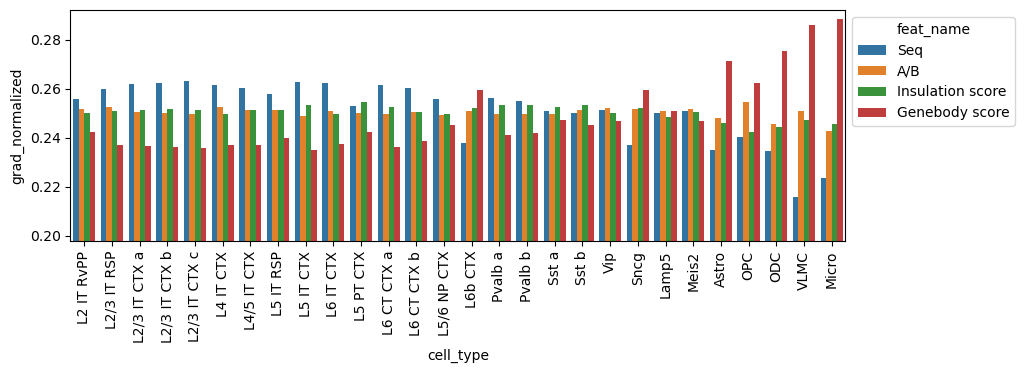

In [94]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, ax = plt.subplots(figsize=(10, 3))
    df = df_grad.groupby(['cell_type', 'feat_name']).grad_normalized.mean().reset_index()
    df = df[df.feat_name.isin([
        'Seq',
        'A/B',
        'Insulation score',
        # 'Insulation score - 50kb',
        # 'Insulation score - 100kb',
        # 'Insulation score - 200kb',
        'Genebody score',
    ])]
    sns.barplot(
        ax=ax, data=df,
        x='cell_type', hue='feat_name', y='grad_normalized',
    )
    mmin, mmax = df.grad_normalized.min(), df.grad_normalized.max()
    p = (mmax - mmin) * .05
    ax.set(ylim=(mmin - p*5, mmax + p))
    ax.tick_params('x', rotation=90)
    sns.move_legend(ax, bbox_to_anchor=(1, 1), loc='upper left')
    path2file = path2figdir / f'gradient_gradnorm_comparison_bar.pdf'
    print(path2file)
    plt.savefig(path2file, dpi=600)
    plt.show()
    plt.close('all')

# Variance of raw input features

In [22]:
df = df_deg_dict['Neu-Glia']
print(len(df))
df = df[df.p_val_adj.le(1e-3) & df.avg_log2FC.le(-.1)]
print(len(df))
gene_id_list = df.gene_id.values
gene_idx_list = np.where(df_meta_gene.gene_id.isin(gene_id_list))[0]
gene_id_list = df_meta_gene.gene_id.iloc[gene_idx_list].values

16983
3941


In [23]:
df = pd.DataFrame([
    dict(
        cell_type=cell_type, feat_name=feat_name,
        value=hic_1d_all[cell_type_idx, :, 150:-150, feat_idx].mean(1).var(0),
    )
    for (cell_type_idx, cell_type), (feat_idx, feat_name) in tqdm(list(itertools.product(
        enumerate(cell_type_list),
        [
            (0, 'A/B'),
            (1, 'Insulation score - 50kb'),
            (2, 'Insulation score - 100kb'),
            (3, 'Insulation score - 200kb'),
            (4, 'Genebody score'),
        ],
    )))
])
# df = df[~df.cell_type.isin(['L5 PT CTX', 'L6b CTX', 'Sncg', 'VLMC', 'Micro'])]
df.value /= df.groupby('feat_name').value.transform('mean')
df.cell_type = pd.Categorical(df.cell_type, categories=list(cell_type_color_map.keys()))
df.feat_name = pd.Categorical(df.feat_name, categories=df.feat_name.unique())
cell_type_mapping = dict(zip(cell_type_color_map.keys(), ['Exc']*15+['Inh']*8+['Glia']*5))
df['major_cell_type'] = pd.Categorical(
    df.cell_type.apply(cell_type_mapping.get), categories=['Exc', 'Inh', 'Glia'])

  0%|          | 0/140 [00:00<?, ?it/s]

In [24]:
# with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)
#     fig, axes = plt.subplots(5, 1, figsize=(10, 10))
#     for ax, (feat_name, df_feat) in zip(axes.flat, df.groupby('feat_name')):
#         sns.barplot(
#             ax=ax, data=df_feat, x='cell_type', y='value',
#             palette=cell_type_color_map, edgecolor='black',
#         )
#         mmin, mmax = df_feat.value.min(), df_feat.value.max()
#         p = (mmax - mmin) * .2
#         ax.set(ylim=(mmin - p, mmax + p), title=feat_name)
#         ax.tick_params('x', rotation=90)
#     fig.tight_layout()
#     plt.show()
#     plt.close('all')

In [25]:
df2 = df[df.feat_name.eq('A/B')]
print('A/B', mannwhitneyu(
    df2.loc[df2.major_cell_type.eq('Exc'), 'value'], df2.loc[~df2.major_cell_type.eq('Exc'), 'value']))
df2 = df[df.feat_name.eq('Insulation score - 100kb')]
print('Insulation score - 100kb', mannwhitneyu(
    df2.loc[df2.major_cell_type.eq('Exc'), 'value'], df2.loc[~df2.major_cell_type.eq('Exc'), 'value']))
print('Insulation score - 100kb', mannwhitneyu(
    df2.loc[df2.major_cell_type.eq('Glia'), 'value'], df2.loc[~df2.major_cell_type.eq('Glia'), 'value']))
df2 = df[df.feat_name.eq('Genebody score')]
print('Genebody score', mannwhitneyu(
    df2.loc[df2.major_cell_type.eq('Glia'), 'value'], df2.loc[~df2.major_cell_type.eq('Glia'), 'value']))

A/B MannwhitneyuResult(statistic=157.0, pvalue=0.0065706567816210025)
Insulation score - 100kb MannwhitneyuResult(statistic=156.0, pvalue=0.0075447859428227045)
Insulation score - 100kb MannwhitneyuResult(statistic=11.0, pvalue=0.0030525030525030525)
Genebody score MannwhitneyuResult(statistic=107.0, pvalue=0.001221001221001221)


/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_featvar_box.pdf


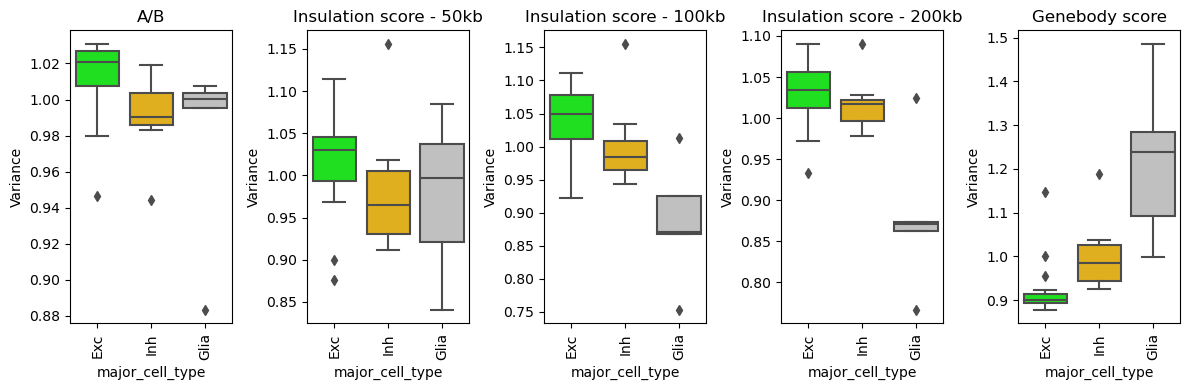

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for ax, (feat_name, df_feat) in zip(axes.flat, df.groupby('feat_name')):
        sns.boxplot(
            ax=ax, data=df_feat, x='major_cell_type', y='value',
            palette={
                a: cell_type_color_map[b]
                for a, b in [('Exc', 'L4 IT CTX'), ('Inh', 'Pvalb a'), ('Glia', 'Astro')]},
        )
        ax.set(title=feat_name, ylabel='Variance')
        ax.tick_params('x', rotation=90)
    path2file = path2figdir / f'gradient_featvar_box.pdf'
    print(path2file)
    plt.savefig(path2file, dpi=600)
    fig.tight_layout()
    plt.show()
    plt.close('all')

# Gradient on some chromHMM state

In [27]:
def chi_square_test_for_var(x, var, alternative='greater'):
    n = len(x)
    stat = (n - 1) * np.var(x) / var
    if alternative == 'smaller':
        pval = chi2.cdf(stat, n-1)
    elif alternative == 'greater':
        pval = chi2.sf(stat, n-1)
    return stat, pval

chi_square_test_for_var(np.random.randn(100) * 1.2, 1)

(163.95384696684167, 4.4323678679608175e-05)

In [28]:
fn = lambda x: x
# fn = lambda x: np.abs(x)
# fn = lambda x: np.log1p(np.abs(x) * 10)

model_id = 'd1xcmvsr'

data_dict_background_mean = {
    (cell_type, model_id, feat_name): np.mean([
        fn(data_dict[gene_id, cell_type, model_id, feat_name].astype(np.float64))
        for gene_id in df_meta_gene.gene_id
    ], axis=0)
    for cell_type, feat_name in tqdm(list(itertools.product(cell_type_list, ['hic_1d'])))
}
data_dict_background_std = {
    (cell_type, model_id, feat_name): np.std([
        fn(data_dict[gene_id, cell_type, model_id, feat_name].astype(np.float64))
        for gene_id in df_meta_gene.gene_id
    ], axis=0)
    for cell_type, feat_name in tqdm(list(itertools.product(cell_type_list, ['hic_1d'])))
}

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [29]:
# %%time

# dfg_meta_gene_by_chrom = df_meta_gene.groupby('chrom')
cell_type_list_subset = [
    ('L2/3 IT CTX a', 'L23'),
    ('L2/3 IT CTX b', 'L23'),
    ('L2/3 IT CTX c', 'L23'),
    ('L4 IT CTX', 'L4'),
    ('L5 IT CTX', 'L5'),
    ('L6 IT CTX', 'L6'),
    ('L5 PT CTX', 'PT'),
    ('L5/6 NP CTX', 'NP'),
    ('L6 CT CTX a', 'CT'),
    ('L6 CT CTX b', 'CT'),
    ('Pvalb a', 'Pvalb'),
    ('Pvalb b', 'Pvalb'),
    ('Sst a', 'Sst'),
    ('Sst b', 'Sst'),
    ('Lamp5', 'CGE'),
    ('Vip', 'CGE'),
    ('Astro', 'Astro_Myoc'),
    # ('Astro', 'Astro_Nnat'),
    ('OPC', 'OPC'),
    # ('ODC', 'Oligo_MFOL'),
    ('ODC', 'Oligo_MOL'),
    ('Micro', 'Microglia'),
]
chromhmm_state = 'E3'
min_bin_idx, max_bin_idx = 100, 197
df_obs = []

def calc(cell_type, chromhmm_idx, row, feat_name, feat_idx, feat_name_str, additional_columns):
    # row = copy.deepcopy(row)
    # row.gene_id = np.random.choice(df_meta_gene.gene_id)
    wp = 0
    wn = 5
    lp, rp = max(row.bin_idx-wp, min_bin_idx), min(row.bin_idx+wp+1, max_bin_idx+1)
    ln, rn = max(row.bin_idx-wn, min_bin_idx), min(row.bin_idx+wn+1, max_bin_idx+1)
    data = data_dict[row.gene_id, cell_type, model_id, feat_name]

    option = 5
    if option == 1:
        x = data[lp: rp, feat_idx].sum()
        y = data[ln: rn, feat_idx].sum()
        y = (y-x) / ((rn-ln)-(rp-lp))
        x /= rp-lp
    elif option == 2:
        slc = (slice(lp, rp), feat_idx)
        x = fn(data_dict[row.gene_id, cell_type, model_id, feat_name][slc]).mean()
        # x = np.mean([
        #     fn(data_dict[gene_id, c, model_id, feat_name][slc]).mean()
        #     for c in cell_type_list
        #     if c == cell_type or (cell_type[-2] == ' ' and c[-2] == ' ' and cell_type[:-2] == c[:-2])
        # ])
        y = np.mean([
            fn(data_dict[row.gene_id, c, model_id, feat_name][slc]).mean()
            for c in cell_type_list
            if c != cell_type and not (cell_type[-2] == ' ' and c[-2] == ' ' and cell_type[:-2] == c[:-2])
            # if c != cell_type
        ])
    elif option == 3:
        x = data[lp: rp, feat_idx].mean()
        y = data[:198, feat_idx].mean()
    elif option == 4:
        x = fn(data[lp: rp, feat_idx]).mean()
        y = data_dict_background_mean[cell_type, model_id, feat_name][lp: rp, feat_idx].mean()
    elif option == 5:
        slc = (slice(lp, rp), feat_idx)
        x = data[slc] - data_dict_background_mean[cell_type, model_id, feat_name][slc]
        x /= data_dict_background_std[cell_type, model_id, feat_name][slc]
        x = x.mean()
        y = 1
    else:
        raise NotImplementedError()
    # --
    return dict(
        chromhmm_idx=chromhmm_idx,
        chrom=row.chrom, gene_id=row.gene_id, gene_idx=row.gene_idx, bin_idx=row.bin_idx,
        feat_name=feat_name, feat_idx=feat_idx, feat_name_str=feat_name_str,
        x=x, y=y, **additional_columns,
    )

for cell_type, cell_type_chromhmm in cell_type_list_subset:
    df_chromhmm = df_chromhmm_enhancer_dict[cell_type_chromhmm]
    df_chromhmm = df_chromhmm[df_chromhmm.state.eq(chromhmm_state)]
    df_chromhmm = df_chromhmm[df_chromhmm.end - df_chromhmm.start < 5_000]
    df_chromhmm = df_chromhmm[df_chromhmm.bin_idx.between(min_bin_idx, max_bin_idx)]
    for chromhmm_idx, row in tqdm(df_chromhmm.iterrows(), desc=cell_type, total=len(df_chromhmm)):
        for feat_name, feat_idx, feat_name_str in [
            ('hic_1d', 0, 'A/B'),
            ('hic_1d', 1, 'Insulation score - 50kb'),
            ('hic_1d', 2, 'Insulation score - 100kb'),
            ('hic_1d', 3, 'Insulation score - 200kb'),
            ('hic_1d', 4, 'Genebody score'),
        ]:
            df_obs.append(calc(
                cell_type,
                chromhmm_idx, row, feat_name, feat_idx, feat_name_str,
                dict(cell_type=cell_type, cell_type_chromhmm=cell_type_chromhmm),
            ))
df_obs = [_ for _ in df_obs if _ is not None]
df_obs = pd.DataFrame(df_obs)

L2/3 IT CTX a:   0%|          | 0/1469 [00:00<?, ?it/s]

L2/3 IT CTX b:   0%|          | 0/1469 [00:00<?, ?it/s]

L2/3 IT CTX c:   0%|          | 0/1469 [00:00<?, ?it/s]

L4 IT CTX:   0%|          | 0/916 [00:00<?, ?it/s]

L5 IT CTX:   0%|          | 0/1361 [00:00<?, ?it/s]

L6 IT CTX:   0%|          | 0/666 [00:00<?, ?it/s]

L5 PT CTX:   0%|          | 0/907 [00:00<?, ?it/s]

L5/6 NP CTX:   0%|          | 0/392 [00:00<?, ?it/s]

L6 CT CTX a:   0%|          | 0/1009 [00:00<?, ?it/s]

L6 CT CTX b:   0%|          | 0/1009 [00:00<?, ?it/s]

Pvalb a:   0%|          | 0/838 [00:00<?, ?it/s]

Pvalb b:   0%|          | 0/838 [00:00<?, ?it/s]

Sst a:   0%|          | 0/777 [00:00<?, ?it/s]

Sst b:   0%|          | 0/777 [00:00<?, ?it/s]

Lamp5:   0%|          | 0/1038 [00:00<?, ?it/s]

Vip:   0%|          | 0/1038 [00:00<?, ?it/s]

Astro:   0%|          | 0/1244 [00:00<?, ?it/s]

OPC:   0%|          | 0/901 [00:00<?, ?it/s]

ODC:   0%|          | 0/850 [00:00<?, ?it/s]

Micro:   0%|          | 0/684 [00:00<?, ?it/s]

In [30]:
df_test = []
for (feat_name, feat_idx, feat_name_str), (cell_type, cell_type_chromhmm) in itertools.product(
    df_obs[['feat_name', 'feat_idx', 'feat_name_str']].drop_duplicates().values, 
    df_obs[['cell_type', 'cell_type_chromhmm']].drop_duplicates().values,
):
    df = df_obs.copy()
    df = df[df.feat_name.eq(feat_name) & df.feat_idx.eq(feat_idx)]
    df = df[df.cell_type.eq(cell_type) & df.cell_type_chromhmm.eq(cell_type_chromhmm)]
    # stat, pval = ttest_rel(df.x, df.y)[:2]
    # stat, pval = chi_square_test_for_var(df.x / df.y, 1, alternative='greater')[:2]
    stat, pval = levene(df.x, df.y)
    log10pval = np.log10(pval)
    df_test.append(dict(
        n=len(df),
        feat_name=feat_name, feat_idx=feat_idx, feat_name_str=feat_name_str,
        cell_type=cell_type, cell_type_chromhmm=cell_type_chromhmm,
        stat=stat, pval=pval, log10pval=log10pval,
    ))
df_test = pd.DataFrame(df_test)
keys = ['feat_name', 'feat_idx', 'cell_type']
pthr = 5e-2
for feat_name, feat_idx in df_test[['feat_name', 'feat_idx']].drop_duplicates().values:
    print(feat_name, feat_idx)
    df = df_test.copy()
    df = df[df.feat_name.eq(feat_name) & df.feat_idx.eq(feat_idx)]
    display(df[df.pval.le(pthr)].sort_values(keys))
    display(df[df.pval.gt(pthr)].sort_values(keys))

hic_1d 0


,n,feat_name,feat_idx,feat_name_str,cell_type,cell_type_chromhmm,stat,pval,log10pval
16,1244,hic_1d,0,A/B,Astro,Astro_Myoc,311.685476,8.244895e-66,-65.083815
0,1469,hic_1d,0,A/B,L2/3 IT CTX a,L23,432.415573,1.041823e-89,-88.982206
1,1469,hic_1d,0,A/B,L2/3 IT CTX b,L23,402.131988,6.155432e-84,-83.210741
2,1469,hic_1d,0,A/B,L2/3 IT CTX c,L23,382.048341,4.429400e-80,-79.353655
3,916,hic_1d,0,A/B,L4 IT CTX,L4,256.423145,4.109233e-54,-53.386239
4,1361,hic_1d,0,A/B,L5 IT CTX,L5,292.364301,2.449940e-62,-61.610845
6,907,hic_1d,0,A/B,L5 PT CTX,PT,204.296470,5.406245e-44,-43.267104
7,392,hic_1d,0,A/B,L5/6 NP CTX,NP,98.852377,5.159353e-22,-21.287405
8,1009,hic_1d,0,A/B,L6 CT CTX a,CT,203.467744,4.721004e-44,-43.325966
9,1009,hic_1d,0,A/B,L6 CT CTX b,CT,124.155962,5.034057e-28,-27.298082


,n,feat_name,feat_idx,feat_name_str,cell_type,cell_type_chromhmm,stat,pval,log10pval


hic_1d 1


,n,feat_name,feat_idx,feat_name_str,cell_type,cell_type_chromhmm,stat,pval,log10pval
36,1244,hic_1d,1,Insulation score - 50kb,Astro,Astro_Myoc,206.408124,5.041314e-45,-44.297456
20,1469,hic_1d,1,Insulation score - 50kb,L2/3 IT CTX a,L23,163.571646,1.734705e-36,-35.760774
21,1469,hic_1d,1,Insulation score - 50kb,L2/3 IT CTX b,L23,326.795361,2.411947e-69,-68.617632
22,1469,hic_1d,1,Insulation score - 50kb,L2/3 IT CTX c,L23,188.571551,1.227093e-41,-40.911123
23,916,hic_1d,1,Insulation score - 50kb,L4 IT CTX,L4,190.901466,2.237302e-41,-40.650275
24,1361,hic_1d,1,Insulation score - 50kb,L5 IT CTX,L5,255.607556,4.642552e-55,-54.333243
26,907,hic_1d,1,Insulation score - 50kb,L5 PT CTX,PT,124.437905,5.388794e-28,-27.268508
27,392,hic_1d,1,Insulation score - 50kb,L5/6 NP CTX,NP,43.485719,7.858371e-11,-10.104667
28,1009,hic_1d,1,Insulation score - 50kb,L6 CT CTX a,CT,167.480648,7.389080e-37,-36.131410
29,1009,hic_1d,1,Insulation score - 50kb,L6 CT CTX b,CT,187.538178,6.970772e-41,-40.156719


,n,feat_name,feat_idx,feat_name_str,cell_type,cell_type_chromhmm,stat,pval,log10pval


hic_1d 2


,n,feat_name,feat_idx,feat_name_str,cell_type,cell_type_chromhmm,stat,pval,log10pval
56,1244,hic_1d,2,Insulation score - 100kb,Astro,Astro_Myoc,222.657098,2.750530e-48,-47.560584
40,1469,hic_1d,2,Insulation score - 100kb,L2/3 IT CTX a,L23,354.993312,7.589481e-75,-74.119788
41,1469,hic_1d,2,Insulation score - 100kb,L2/3 IT CTX b,L23,318.213938,1.165581e-67,-66.933458
42,1469,hic_1d,2,Insulation score - 100kb,L2/3 IT CTX c,L23,217.356035,1.636660e-47,-46.786041
43,916,hic_1d,2,Insulation score - 100kb,L4 IT CTX,L4,239.671601,6.759818e-51,-50.170065
44,1361,hic_1d,2,Insulation score - 100kb,L5 IT CTX,L5,265.718027,4.525496e-57,-56.344334
46,907,hic_1d,2,Insulation score - 100kb,L5 PT CTX,PT,155.143980,3.143200e-34,-33.502628
47,392,hic_1d,2,Insulation score - 100kb,L5/6 NP CTX,NP,72.192901,9.803540e-17,-16.008617
48,1009,hic_1d,2,Insulation score - 100kb,L6 CT CTX a,CT,161.010717,1.497925e-35,-34.824510
49,1009,hic_1d,2,Insulation score - 100kb,L6 CT CTX b,CT,174.292351,3.141572e-38,-37.502853


,n,feat_name,feat_idx,feat_name_str,cell_type,cell_type_chromhmm,stat,pval,log10pval


hic_1d 3


,n,feat_name,feat_idx,feat_name_str,cell_type,cell_type_chromhmm,stat,pval,log10pval
76,1244,hic_1d,3,Insulation score - 200kb,Astro,Astro_Myoc,194.584976,1.230366e-42,-41.909966
60,1469,hic_1d,3,Insulation score - 200kb,L2/3 IT CTX a,L23,371.685968,4.423773e-78,-77.354207
61,1469,hic_1d,3,Insulation score - 200kb,L2/3 IT CTX b,L23,383.775518,2.059219e-80,-79.686297
62,1469,hic_1d,3,Insulation score - 200kb,L2/3 IT CTX c,L23,392.459092,4.405361e-82,-81.356019
63,916,hic_1d,3,Insulation score - 200kb,L4 IT CTX,L4,226.825617,2.063363e-48,-47.685424
64,1361,hic_1d,3,Insulation score - 200kb,L5 IT CTX,L5,301.011670,4.902434e-64,-63.309588
66,907,hic_1d,3,Insulation score - 200kb,L5 PT CTX,PT,150.001588,3.419520e-33,-32.466035
67,392,hic_1d,3,Insulation score - 200kb,L5/6 NP CTX,NP,99.803405,3.369393e-22,-21.472448
68,1009,hic_1d,3,Insulation score - 200kb,L6 CT CTX a,CT,256.438126,2.014505e-54,-53.695832
69,1009,hic_1d,3,Insulation score - 200kb,L6 CT CTX b,CT,201.736441,1.040684e-43,-42.982681


,n,feat_name,feat_idx,feat_name_str,cell_type,cell_type_chromhmm,stat,pval,log10pval


hic_1d 4


,n,feat_name,feat_idx,feat_name_str,cell_type,cell_type_chromhmm,stat,pval,log10pval
96,1244,hic_1d,4,Genebody score,Astro,Astro_Myoc,228.959828,1.510965e-49,-48.820746
80,1469,hic_1d,4,Genebody score,L2/3 IT CTX a,L23,434.885508,3.543281e-90,-89.450594
81,1469,hic_1d,4,Genebody score,L2/3 IT CTX b,L23,494.389068,2.342021e-101,-100.630409
82,1469,hic_1d,4,Genebody score,L2/3 IT CTX c,L23,389.882114,1.377307e-81,-80.860969
83,916,hic_1d,4,Genebody score,L4 IT CTX,L4,182.130291,1.222808e-39,-38.912642
84,1361,hic_1d,4,Genebody score,L5 IT CTX,L5,277.639881,1.964997e-59,-58.706638
86,907,hic_1d,4,Genebody score,L5 PT CTX,PT,164.874476,3.498527e-36,-35.456115
87,392,hic_1d,4,Genebody score,L5/6 NP CTX,NP,71.214187,1.544171e-16,-15.811304
88,1009,hic_1d,4,Genebody score,L6 CT CTX a,CT,223.860365,4.483172e-48,-47.348415
89,1009,hic_1d,4,Genebody score,L6 CT CTX b,CT,149.101195,3.910240e-33,-32.407797


,n,feat_name,feat_idx,feat_name_str,cell_type,cell_type_chromhmm,stat,pval,log10pval


hic_1d 0


  0%|          | 0/20 [00:00<?, ?it/s]

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_variance_kde_AB.pdf


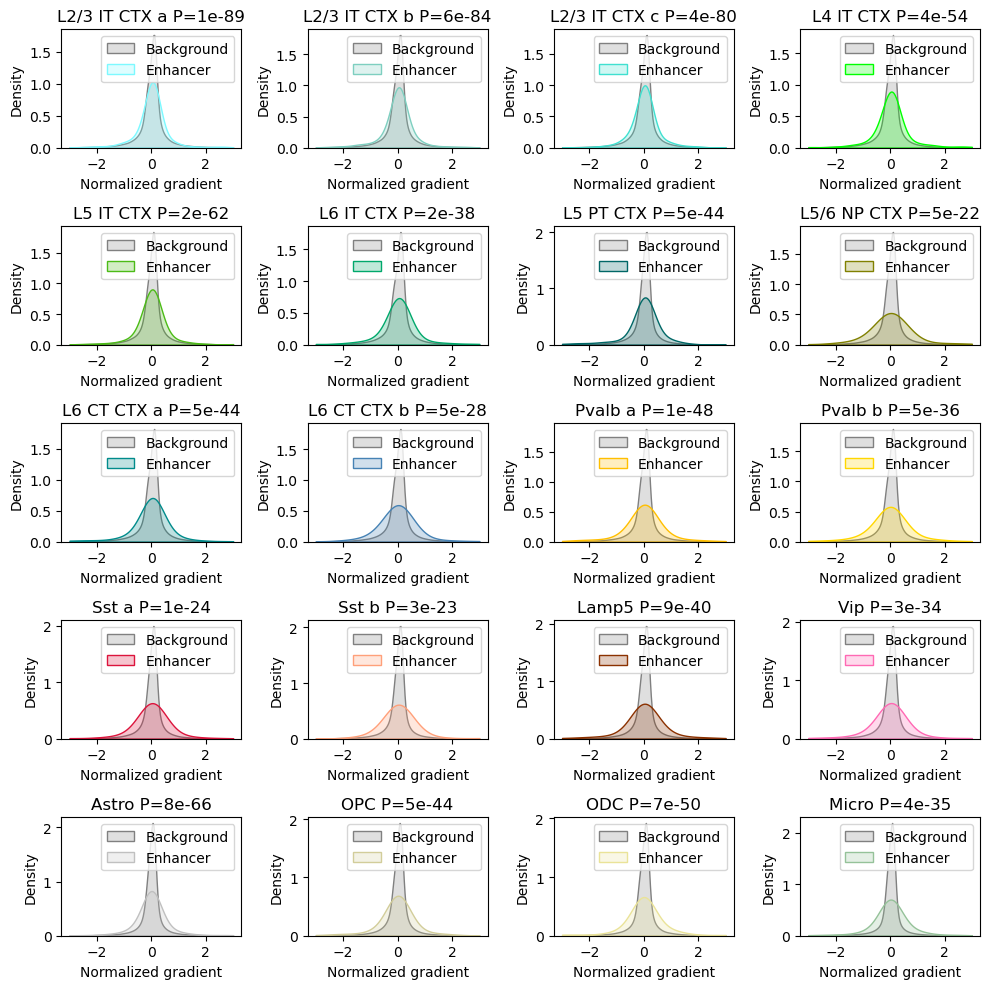

hic_1d 1


  0%|          | 0/20 [00:00<?, ?it/s]

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_variance_kde_Insulation-score---50kb.pdf


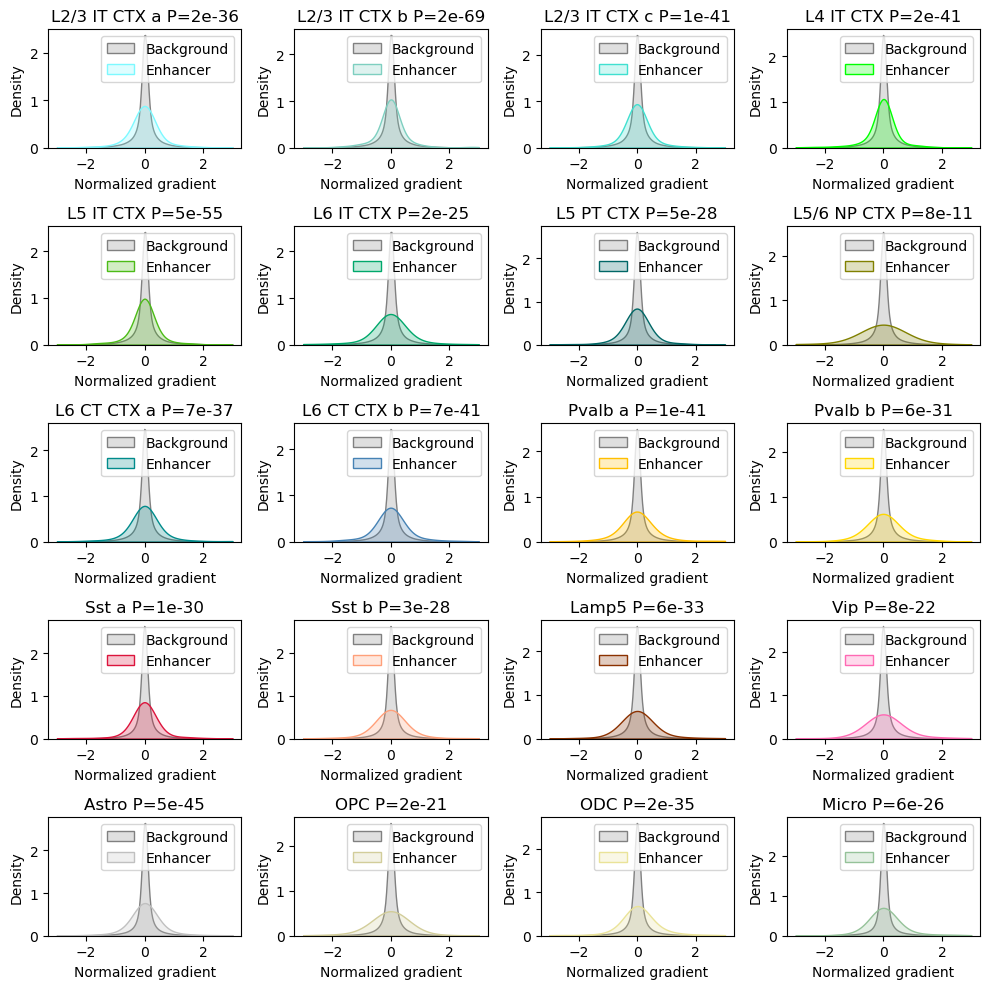

hic_1d 2


  0%|          | 0/20 [00:00<?, ?it/s]

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_variance_kde_Insulation-score---100kb.pdf


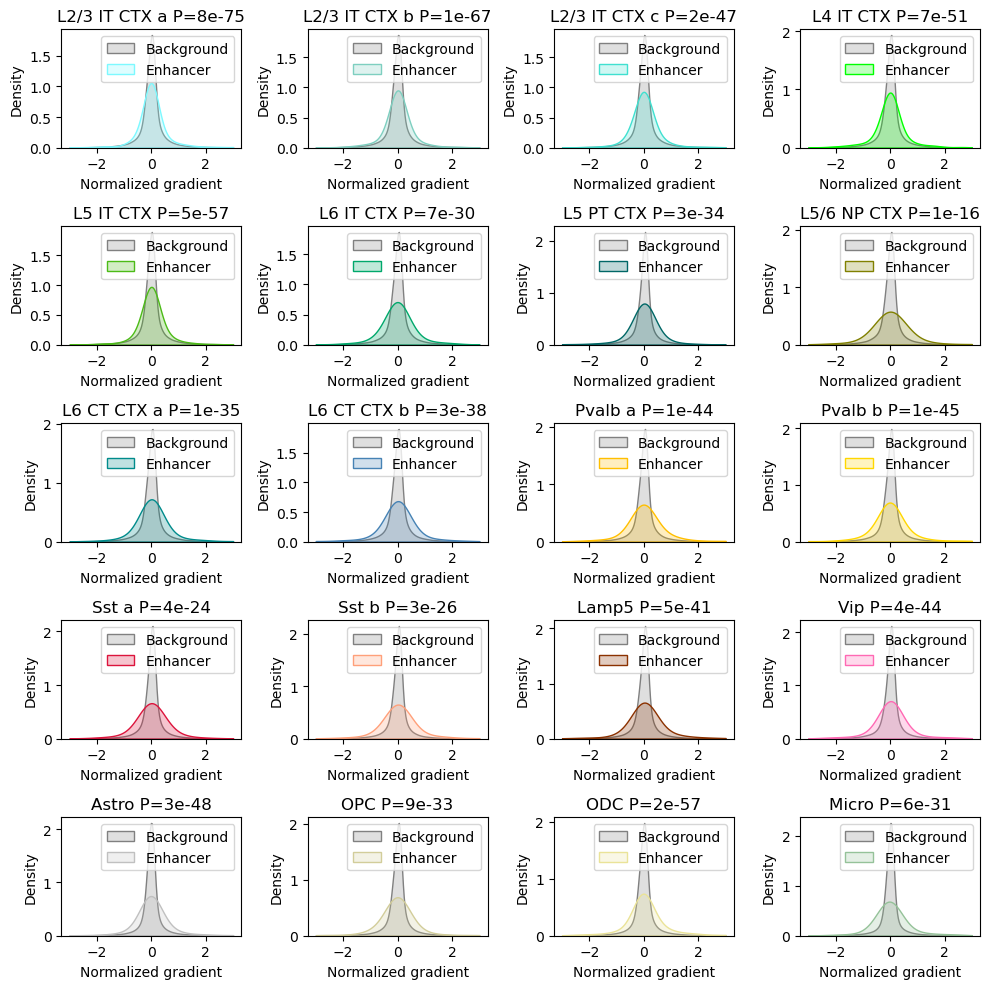

hic_1d 3


  0%|          | 0/20 [00:00<?, ?it/s]

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_variance_kde_Insulation-score---200kb.pdf


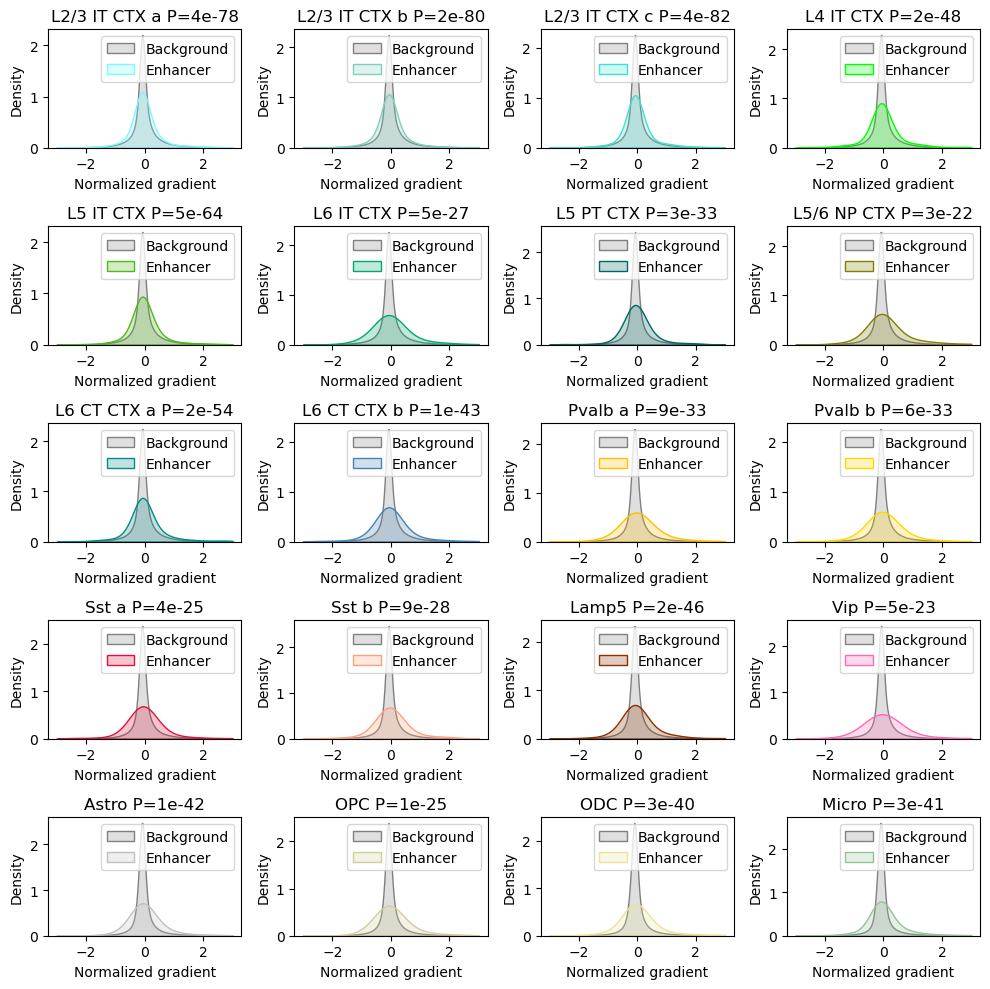

hic_1d 4


  0%|          | 0/20 [00:00<?, ?it/s]

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_variance_kde_Genebody-score.pdf


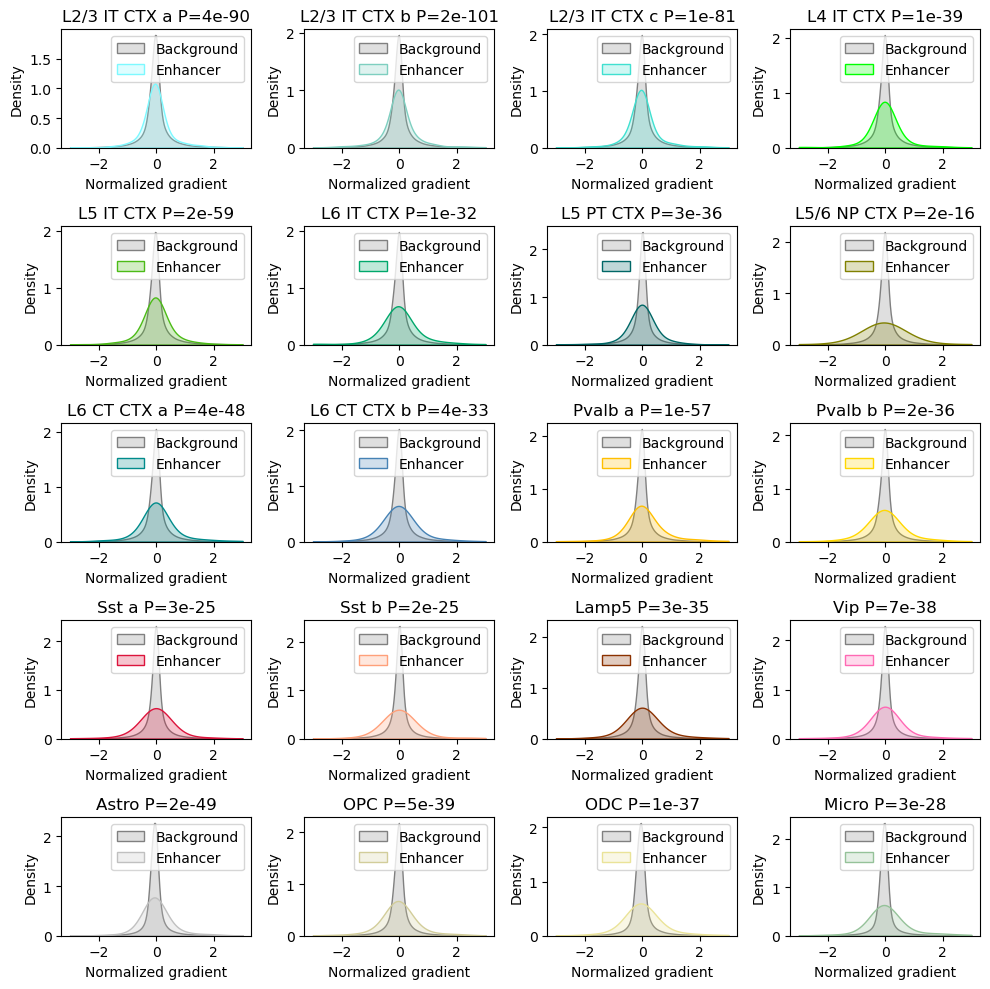

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for feat_name, feat_idx, feat_name_str in df_obs[['feat_name', 'feat_idx', 'feat_name_str']]\
        .drop_duplicates().values:
        print(feat_name, feat_idx)
        fig, axes = plt.subplots(5, 4, figsize=(10, 10))
        for ax, (cell_type, cell_type_chromhmm) in tqdm(list(zip(
            axes.flat, df_obs[['cell_type', 'cell_type_chromhmm']].drop_duplicates().values))):
            df = df_obs.copy()
            df = df[df.feat_name.eq(feat_name) & df.feat_idx.eq(feat_idx)]
            df = df[df.cell_type.eq(cell_type) & df.cell_type_chromhmm.eq(cell_type_chromhmm)]
            slc = (slice(min_bin_idx, max_bin_idx), feat_idx)
            x = np.stack([
                (
                    fn(data_dict[gene_id, cell_type, model_id, feat_name][slc]) - 
                    data_dict_background_mean[cell_type, model_id, feat_name][slc]
                ) / data_dict_background_std[cell_type, model_id, feat_name][slc]
                for gene_id in df_meta_gene.gene_id
            ], axis=0).ravel().astype(np.float64)
            clip = (-3, 3)
            sns.kdeplot(
                ax=ax, data=x, label='Background', clip=clip, color='grey', fill=True)
            sns.kdeplot(
                ax=ax, data=df.x, label='Enhancer', clip=clip,
                color=cell_type_color_map[cell_type], fill=True)
            ax.legend()
            pval = df_test.set_index(['feat_name', 'feat_idx', 'cell_type', 'cell_type_chromhmm'])\
                .loc[(feat_name, feat_idx, cell_type, cell_type_chromhmm)].pval
            ax.set(xlabel='Normalized gradient', title=f'{cell_type} P={pval:.0e}')
            # break
        fig.tight_layout()
        path2file = path2figdir / \
            f"gradient_variance_kde_{feat_name_str.replace(' ', '-').replace('/', '')}.pdf"
        print(path2file)
        plt.savefig(path2file, dpi=600)
        plt.show()
        plt.close('all')

# Comparison of TFBS in enhancer among cell types

In [32]:
df_tfbs

,tf_name,chrom,start,end,strand,pos
0,MA0485.1,mm10_chr3,107954083,107954095,+,107954089
1,MA0485.1,mm10_chr3,107987606,107987618,+,107987612
2,MA0485.1,mm10_chr3,107995543,107995555,+,107995549
3,MA0485.1,mm10_chr3,108010225,108010237,+,108010231
4,MA0485.1,mm10_chr3,108012001,108012013,+,108012007
...,...,...,...,...,...,...
81645326,MA0027.1,mm10_chr16,13847754,13847764,-,13847759
81645327,MA0027.1,mm10_chr16,13860777,13860787,-,13860782
81645328,MA0027.1,mm10_chr16,13863565,13863575,-,13863570
81645329,MA0027.1,mm10_chr16,13902969,13902979,-,13902974


In [33]:
df_chromhmm_enhancer_dict['L23']

,chrom,start,end,state,pos,gene_idx,gene_id,bin_idx
0,mm10_chr10,5437000,5440000,E3,5438500,408,ENSMUSG00000019772,396
1,mm10_chr10,5445000,5449000,E3,5447000,408,ENSMUSG00000019772,387
2,mm10_chr10,5480000,5481000,E3,5480500,408,ENSMUSG00000019772,354
3,mm10_chr10,5547000,5549000,E3,5548000,408,ENSMUSG00000019772,289
4,mm10_chr10,5852000,5855000,E3,5853500,409,ENSMUSG00000019774,171
...,...,...,...,...,...,...,...,...
6491,mm10_chr9,122271000,122275000,E3,122273000,1812,ENSMUSG00000032540,276
6492,mm10_chr9,122308000,122311000,E3,122309500,1812,ENSMUSG00000032540,241
6493,mm10_chr9,122355000,122357000,E3,122356000,1812,ENSMUSG00000032540,195
6494,mm10_chr9,122528000,122530000,E3,122529000,1812,ENSMUSG00000032540,26


In [34]:
%%time
dfg_tfbs = {k: df for k, df in tqdm(df_tfbs.groupby('chrom'))}

  0%|          | 0/19 [00:00<?, ?it/s]

CPU times: user 16.8 s, sys: 9.75 s, total: 26.6 s
Wall time: 26.6 s


In [35]:
df_enhancer_all = defaultdict(lambda: [])
for cell_type, df_enhancer in tqdm(df_chromhmm_enhancer_dict.items()):
    if cell_type not in [
        'Astro_Myoc', 'Astro_Nnat',
        'CGE', 'CT', 'L23', 'L4', 'L5', 'L6', 'Microglia',
        'NP', 'OPC', 'Oligo_MFOL', 'Oligo_MOL', 'PT', 'Pvalb', 'Sst'
    ]:
        continue
    for chrom, df_enhancer_chrom in df_enhancer.groupby('chrom'):
        df_enhancer_chrom = df_enhancer_chrom.copy()
        df_enhancer_chrom['cell_type'] = cell_type
        df_enhancer_all[chrom].append(df_enhancer_chrom)
df_enhancer_all = {k: pd.concat(v) for k, v in df_enhancer_all.items()}

df_enhancer_tfbs = []
for chrom, df_enhancer_chrom in tqdm(df_enhancer_all.items()):
    df_tfbs_chrom = dfg_tfbs[chrom]
    adj = NearestNeighbors(radius=500, n_jobs=8).fit(df_enhancer_chrom.pos.values[:, None])\
        .radius_neighbors_graph(df_tfbs_chrom.pos.values[:, None]).tocoo()
    df = pd.concat([
        df_enhancer_chrom[['chrom', 'gene_id', 'bin_idx', 'cell_type']].iloc[adj.col].reset_index(drop=True),
        df_tfbs_chrom[['tf_name']].iloc[adj.row].reset_index(drop=True),
    ], axis=1)
    df_enhancer_tfbs.append(df)
df_enhancer_tfbs = pd.concat(df_enhancer_tfbs)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [36]:
df = df_enhancer_tfbs
# df = df[df['bin_idx'].between(-np.inf, 199)]
print(len(df))
df_test = df.groupby(['cell_type', 'gene_id', 'chrom']).size().rename('tfbs_count').reset_index()
df_test['has_tfbs'] = df_test.tfbs_count > 0
mapping = {
    'L23': 'Exc',
    'L4': 'Exc',
    'L5': 'Exc',
    'L6': 'Exc',
    'CT': 'Exc',
    'PT': 'Exc',
    'NP': 'Exc',
    'CGE': 'Inh',
    'Pvalb': 'Inh',
    'Sst': 'Inh',
    'Astro_Myoc': 'Glia',
    'Astro_Nnat': 'Glia',
    'OPC': 'Glia',
    'Oligo_MFOL': 'Glia',
    'Oligo_MOL': 'Glia',
    'Microglia': 'Glia',
    'Subiculum': 'Unk',
    'DG': 'Unk',
    'Endothelial': 'Unk',
    'Ependymal': 'Unk',
    'CA1': 'Unk',
    'CA23': 'Unk',
}
df_test.cell_type = pd.Categorical(df_test.cell_type, categories=list(mapping.keys()))
df_test['major_cell_type'] = pd.Categorical(
    df_test.cell_type.apply(mapping.get), categories=['Exc', 'Inh', 'Glia', 'Unk'])

3152610


/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_tfbs_majortype_scatter.pdf


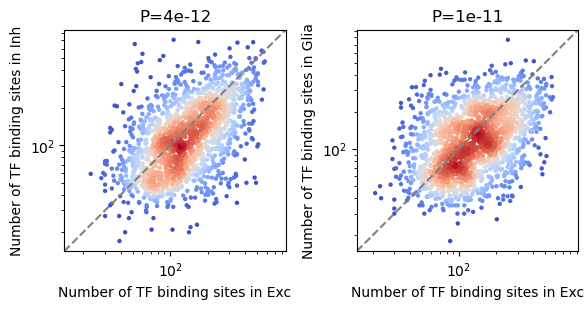

In [47]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    df_all = df_test.groupby(['gene_id', 'major_cell_type'], observed=True).tfbs_count.mean().unstack().fillna(0)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=False, sharey=False)
    for ax, cell_type in zip(axes.flat, ['Inh', 'Glia']):
        df = df_all.copy()
        # df += 1
        df = df[df[['Exc', cell_type]].ne(0).all(1)]
        x = df[['Exc', cell_type]].values
        x = np.log(x)
        density = KernelDensity(bandwidth=.12).fit(x).score_samples(x)
        density = np.exp(density)
        sns.scatterplot(
            ax=ax, x='Exc', y=cell_type, s=10, data=df,
            hue=density, palette='coolwarm', edgecolor='none')
        ax.get_legend().remove()
        t = df.Exc.mean()
        ax.axline((t, t), (t+1, t+1), linestyle='--', color='grey')
        # ax.axline(((df['Exc']-df[cell_type]).mean(), 0), slope=1, linestyle='--', color='C0')
        stat, pval = ttest_rel(df['Exc'], df[cell_type], alternative='greater')
        ax.set(title=f'P={pval:.0e}')
        ax.set_aspect('equal', 'box')
        ax.set(xscale='log', yscale='log')
        lim = min(min(ax.get_xlim()), min(ax.get_ylim())), max(max(ax.get_xlim()), max(ax.get_ylim()))
        ax.set(xlim=lim, ylim=lim)
        ax.set(
            xlabel=f'Number of TF binding sites in {ax.get_xlabel()}',
            ylabel=f'Number of TF binding sites in {ax.get_ylabel()}',
        )
    fig.tight_layout()
    path2file = path2figdir / f"gradient_tfbs_majortype_scatter.pdf"
    print(path2file)
    plt.savefig(path2file, dpi=600)
    plt.show()
    plt.close('all')

In [48]:
# with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)
#     df = df_test.groupby(['major_cell_type']).agg(
#         tfbs_count=pd.NamedAgg(column='tfbs_count', aggfunc="mean"),
#         has_tfbs=pd.NamedAgg(column='has_tfbs', aggfunc="mean"),
#     )
#     df.tfbs_count /= df.has_tfbs
#     df = df.reset_index()
#     df = df[df.major_cell_type.ne('Unk')]
#     display(df)
#     fig, ax = plt.subplots(figsize=(3, 3))
#     sns.scatterplot(
#         ax=ax, data=df, x='major_cell_type', y=np.zeros(len(df)), hue='tfbs_count', size='has_tfbs')
#     sns.move_legend(ax, bbox_to_anchor=(1, 1), loc='upper left')
#     plt.show()
#     plt.close('all')

,cell_type,major_cell_type,tfbs_count,has_tfbs
0,L23,Exc,213.515281,1.0
1,L4,Exc,164.224368,1.0
2,L5,Exc,193.852665,1.0
3,L6,Exc,140.965187,1.0
4,CT,Exc,172.298113,1.0
5,PT,Exc,160.239264,1.0
6,NP,Exc,111.321340,1.0
7,CGE,Inh,169.477612,1.0
8,Pvalb,Inh,155.746167,1.0
9,Sst,Inh,141.694561,1.0


MannwhitneyuResult(statistic=13.0, pvalue=0.3333333333333333)
MannwhitneyuResult(statistic=27.0, pvalue=0.2226107226107226)
TtestResult(statistic=0.6384277756868654, pvalue=0.27058064995033526, df=7.942907555142461)
TtestResult(statistic=0.9152609683844504, pvalue=0.19132465150180894, df=9.521409784962636)


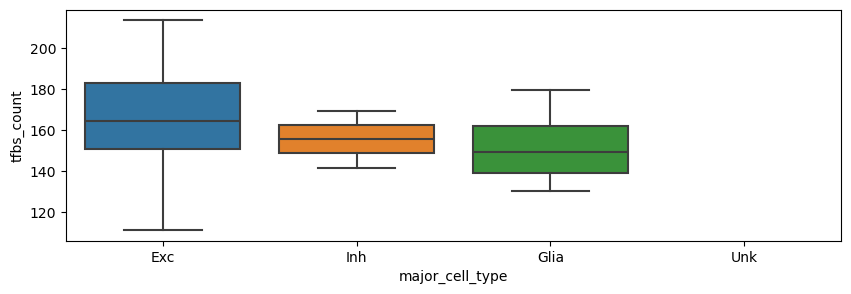

In [49]:
df = df_test.copy()
df = df[df.major_cell_type.ne('Unk')]
df.cell_type = df.cell_type.cat.remove_unused_categories()
df = df.groupby(['cell_type', 'major_cell_type'], observed=True).agg(
    tfbs_count=pd.NamedAgg(column='tfbs_count', aggfunc="mean"),
    has_tfbs=pd.NamedAgg(column='has_tfbs', aggfunc="mean"),
).reset_index()
display(df)
print(mannwhitneyu(
    df[df.major_cell_type.eq('Exc')].tfbs_count, df[df.major_cell_type.eq('Inh')].tfbs_count, alternative='greater'))
print(mannwhitneyu(
    df[df.major_cell_type.eq('Exc')].tfbs_count, df[df.major_cell_type.eq('Glia')].tfbs_count, alternative='greater'))
print(ttest_ind(
    df[df.major_cell_type.eq('Exc')].tfbs_count, df[df.major_cell_type.eq('Inh')].tfbs_count,
    alternative='greater', equal_var=False))
print(ttest_ind(
    df[df.major_cell_type.eq('Exc')].tfbs_count, df[df.major_cell_type.eq('Glia')].tfbs_count,
    alternative='greater', equal_var=False))
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, ax = plt.subplots(figsize=(10, 3))
    sns.boxplot(ax=ax, data=df, x='major_cell_type', y='tfbs_count')
    plt.show()
    plt.close('all')

# Importance of regions per feature

In [70]:
def plot(ax, data, w=1):
    data = data.reshape(*data.shape[:-1], -1, w).mean(-1)
    mu = data.mean(0)
    std = data.std(0)
    l = data.shape[-1] // 2
    ax.bar(x=np.arange(-l, l)+.5, height=mu, width=1)
    # ax.bar(x=np.arange(-l, l), height=mu, yerr=std, width=1)
    # ax.axvline(-.5, c='grey', linestyle='--')
    ax.set_xticks(np.linspace(-l, l, 3))

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_importance_genome_seq_bar.pdf


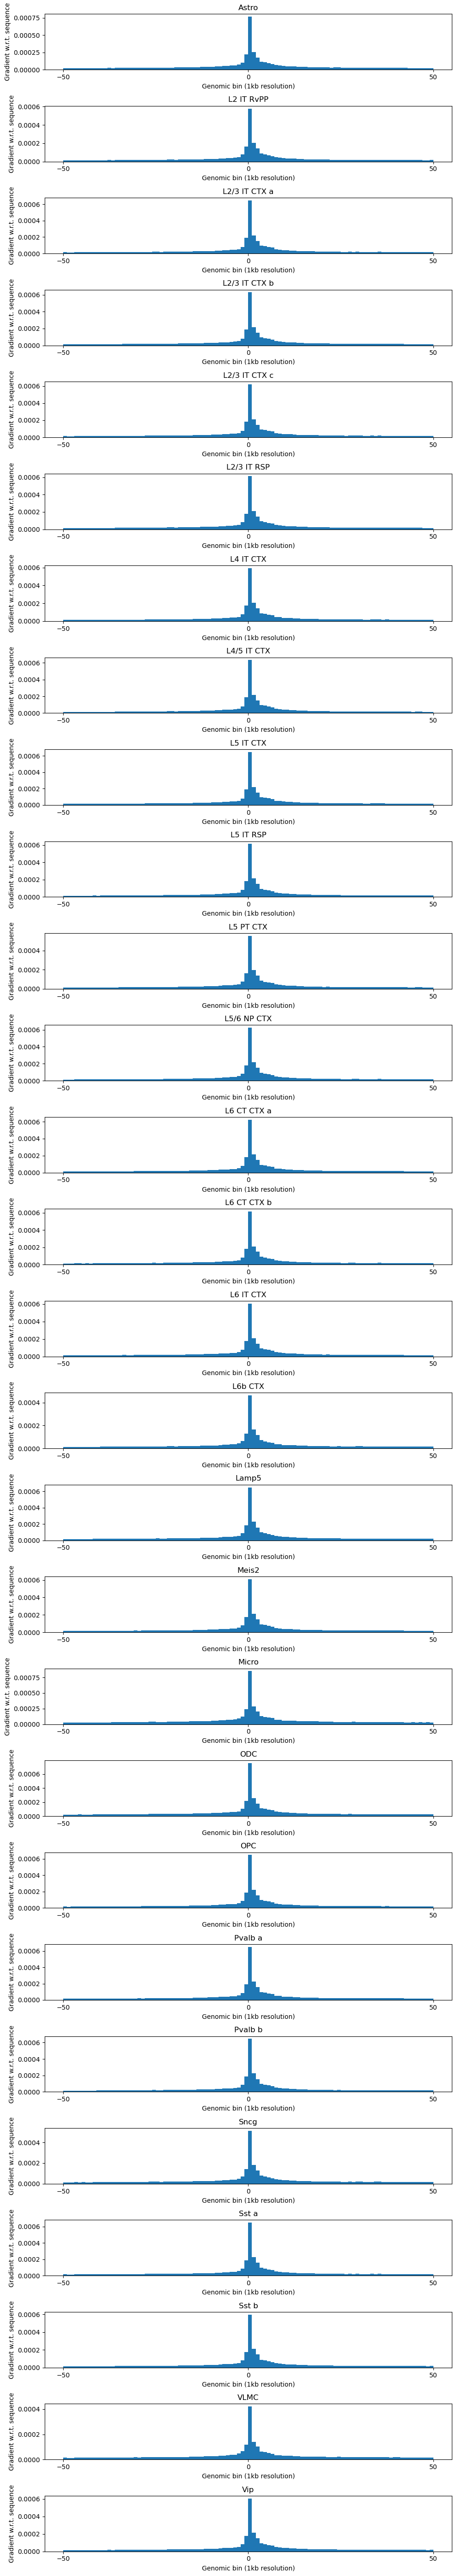

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_importance_genome_seq_agg_bar.pdf


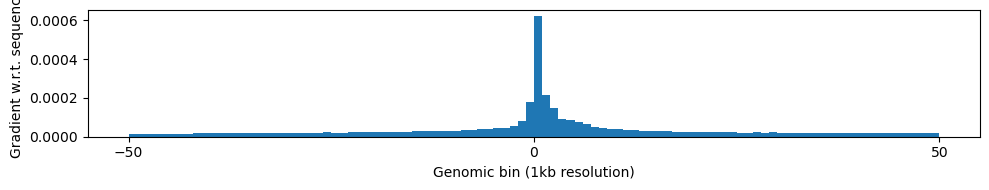

In [77]:
model_id = 'd1xcmvsr'
feat_name = 'seq_l2'
c_list = cell_type_list[::1]
slc = slice(1200, -1200)

nrow = len(c_list)
fig, axes = plt.subplots(nrow, 1, figsize=(10, 2*nrow))
for ax, cell_type in zip(axes.flat, c_list):
    keys = [(gene_id, cell_type, model_id, feat_name) for gene_id in df_meta_gene.gene_id]
    data = np.stack([data_dict[key][slc] for key in keys], axis=0)
    plot(ax, data, w=8)
    ax.set(title=cell_type, xlabel='Genomic bin (1kb resolution)', ylabel='Gradient w.r.t. sequence')
path2file = path2figdir / f"gradient_importance_genome_seq_bar.pdf"
print(path2file)
plt.savefig(path2file, dpi=600)
fig.tight_layout()
plt.show()
plt.close('all')

fig, ax = plt.subplots(figsize=(10, 2))
keys = [
    (gene_id, cell_type, model_id, feat_name)
    for gene_id in df_meta_gene.gene_id
    for cell_type in c_list
]
data = np.stack([data_dict[key][slc] for key in keys], axis=0)
plot(ax, data, w=8)
ax.set(xlabel='Genomic bin (1kb resolution)', ylabel='Gradient w.r.t. sequence')
path2file = path2figdir / f"gradient_importance_genome_seq_agg_bar.pdf"
print(path2file)
plt.savefig(path2file, dpi=600)
fig.tight_layout()
plt.show()
plt.close('all')

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_importance_genome_ab_bar.pdf


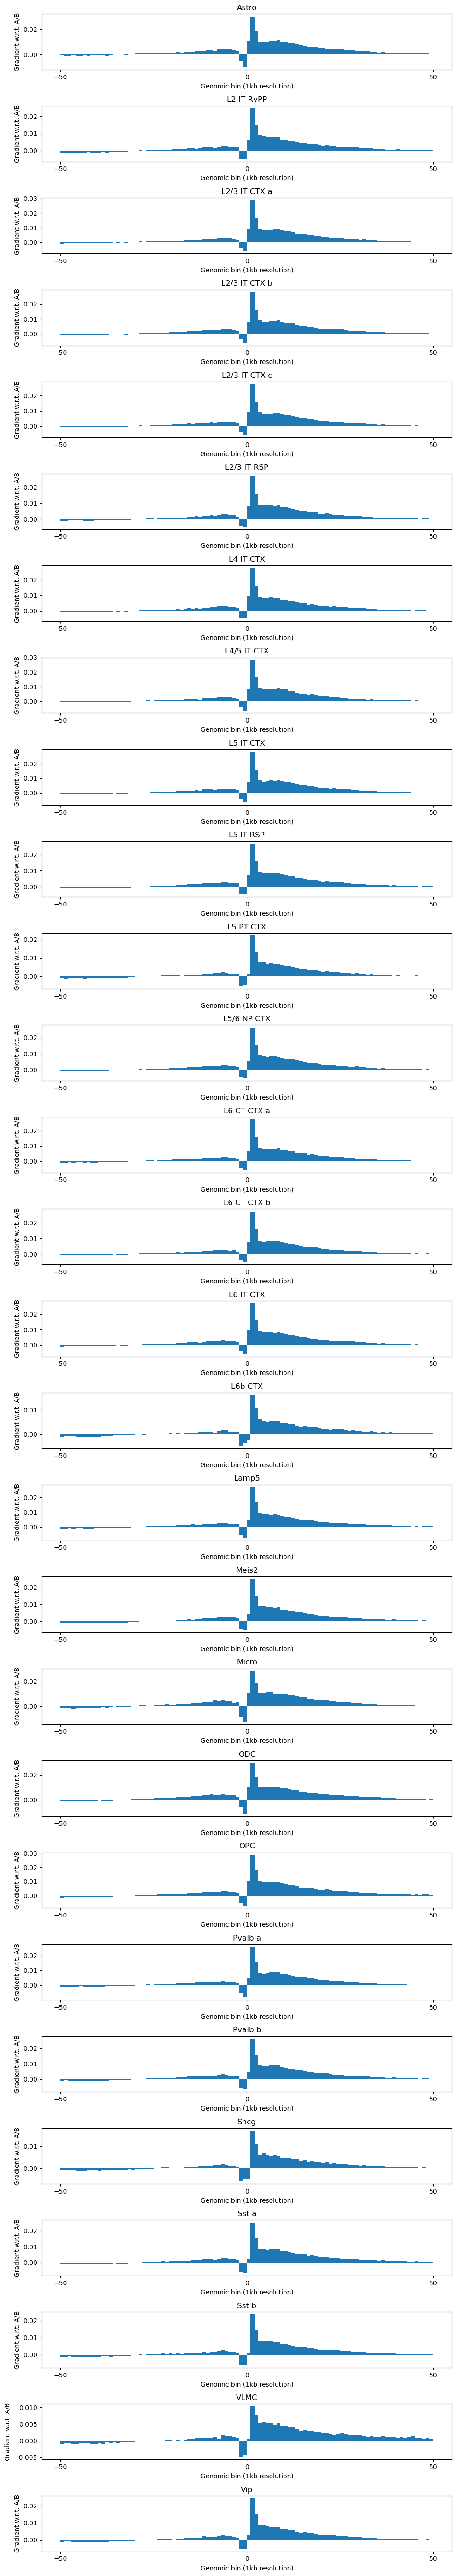

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_importance_genome_ab_agg_bar.pdf


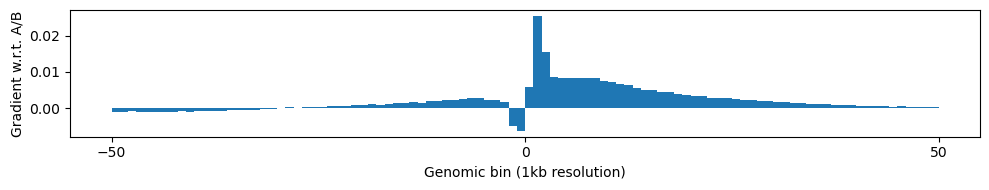

In [80]:
model_id = 'd1xcmvsr'
feat_name = 'hic_1d'
c_list = cell_type_list[::1]
slc = slice(150, -150)

nrow = len(c_list)
fig, axes = plt.subplots(nrow, 1, figsize=(10, 2*nrow))
for ax, cell_type in zip(axes.flat, c_list):
    keys = [(gene_id, cell_type, model_id, feat_name) for gene_id in df_meta_gene.gene_id]
    data = np.stack([data_dict[key][slc, 0] for key in keys], axis=0)
    plot(ax, data)
    ax.set(title=cell_type, xlabel='Genomic bin (1kb resolution)', ylabel='Gradient w.r.t. A/B')
path2file = path2figdir / f"gradient_importance_genome_ab_bar.pdf"
print(path2file)
plt.savefig(path2file, dpi=600)
fig.tight_layout()
plt.show()
plt.close('all')

fig, ax = plt.subplots(figsize=(10, 2))
keys = [
    (gene_id, cell_type, model_id, feat_name)
    for gene_id in df_meta_gene.gene_id
    for cell_type in c_list
]
data = np.stack([data_dict[key][slc, 0] for key in keys], axis=0)
plot(ax, data)
ax.set(xlabel='Genomic bin (1kb resolution)', ylabel='Gradient w.r.t. A/B')
path2file = path2figdir / f"gradient_importance_genome_ab_agg_bar.pdf"
print(path2file)
plt.savefig(path2file, dpi=600)
fig.tight_layout()
plt.show()
plt.close('all')

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_importance_genome_is_bar.pdf


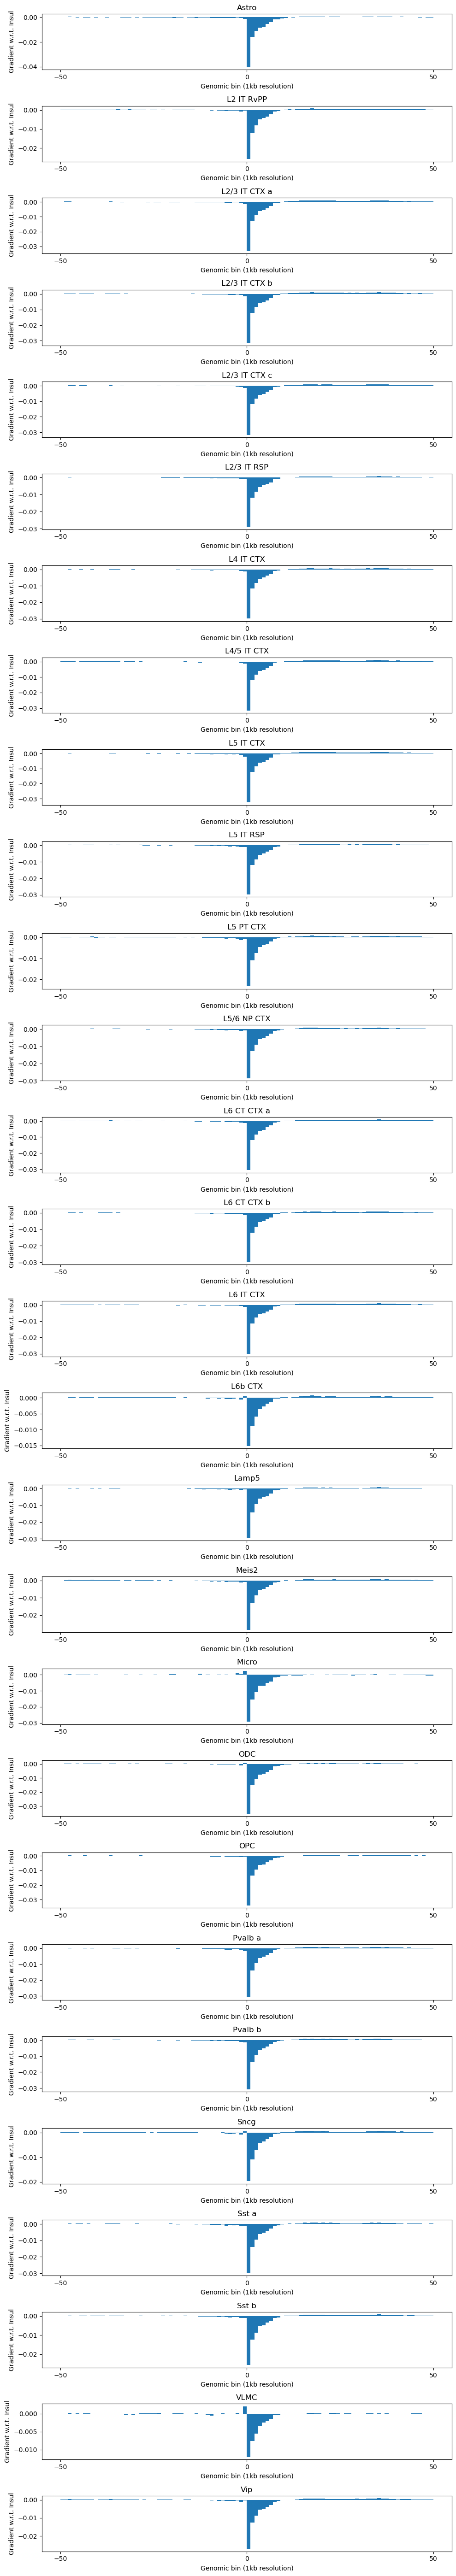

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_importance_genome_is_agg_bar.pdf


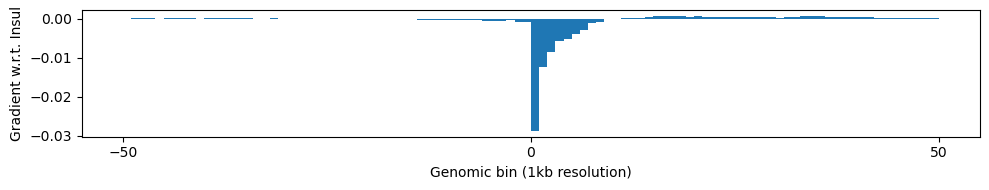

In [84]:
model_id = 'd1xcmvsr'
feat_name = 'hic_1d'
slc = slice(150, -150)

c_list = cell_type_list[::1]
nrow = len(c_list)
fig, axes = plt.subplots(nrow, 1, figsize=(10, 2*nrow))
for ax, cell_type in zip(axes.flat, c_list):
    keys = [(gene_id, cell_type, model_id, feat_name) for gene_id in df_meta_gene.gene_id]
    data = np.stack([data_dict[key][slc, 1] for key in keys], axis=0)
    plot(ax, data)
    ax.set(title=cell_type, xlabel='Genomic bin (1kb resolution)', ylabel='Gradient w.r.t. Insul')
path2file = path2figdir / f"gradient_importance_genome_is_bar.pdf"
print(path2file)
plt.savefig(path2file, dpi=600)
fig.tight_layout()
plt.show()
plt.close('all')

fig, ax = plt.subplots(figsize=(10, 2))
keys = [
    (gene_id, cell_type, model_id, feat_name)
    for gene_id in df_meta_gene.gene_id
    for cell_type in c_list
]
data = np.stack([data_dict[key][slc, 1] for key in keys], axis=0)
plot(ax, data)
ax.set(xlabel='Genomic bin (1kb resolution)', ylabel='Gradient w.r.t. Insul')
path2file = path2figdir / f"gradient_importance_genome_is_agg_bar.pdf"
print(path2file)
plt.savefig(path2file, dpi=600)
fig.tight_layout()
plt.show()
plt.close('all')

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_importance_genome_gb_bar.pdf


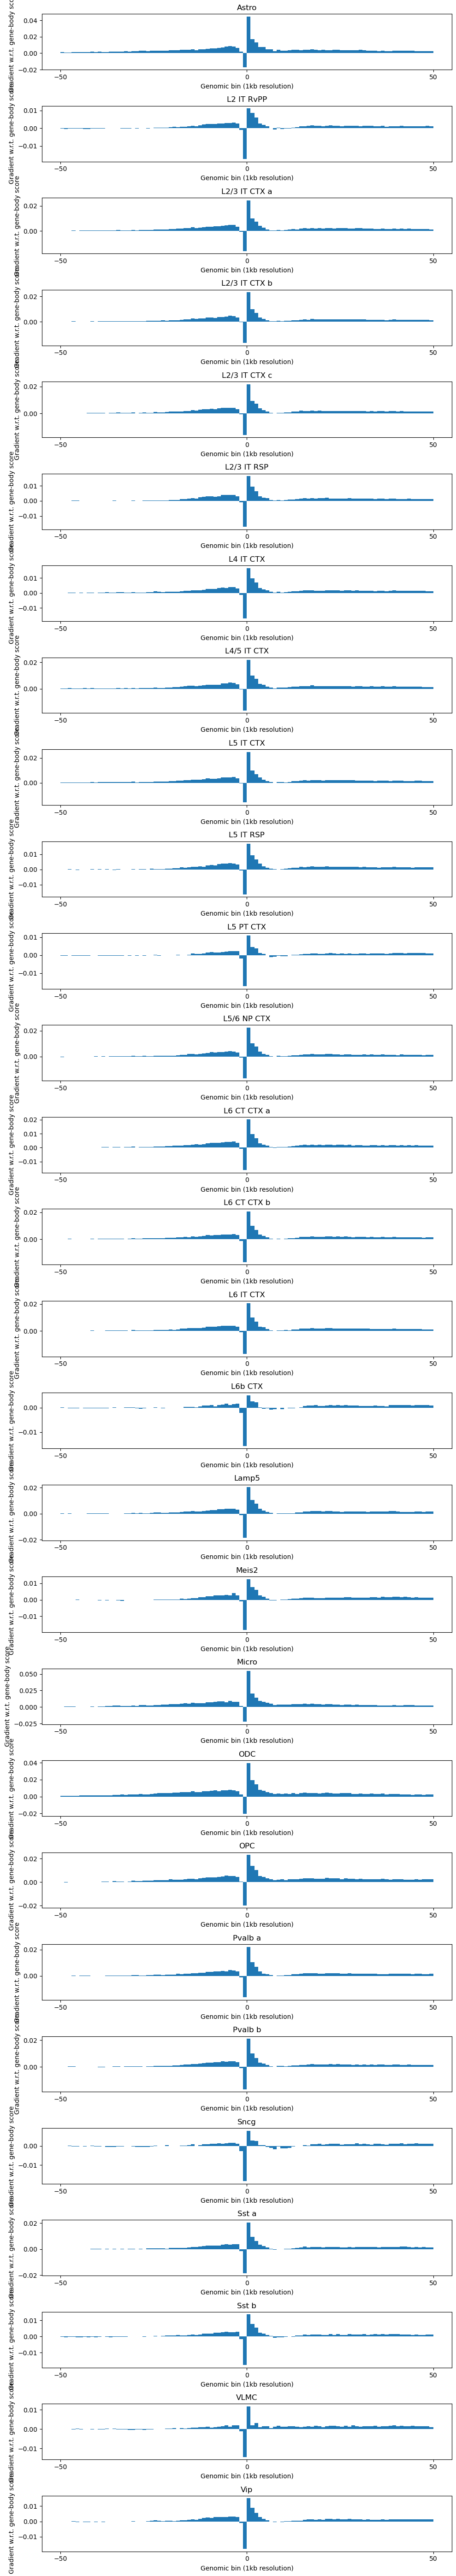

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_importance_genome_gb_agg_bar.pdf


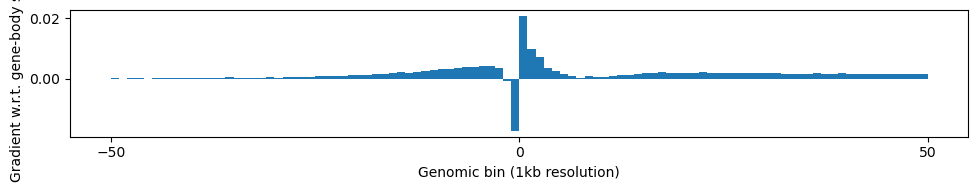

In [82]:
model_id = 'd1xcmvsr'
feat_name = 'hic_1d'
slc = slice(150, -150)

c_list = cell_type_list[::1]
nrow = len(c_list)
fig, axes = plt.subplots(nrow, 1, figsize=(10, 2*nrow))
for ax, cell_type in zip(axes.flat, c_list):
    keys = [(gene_id, cell_type, model_id, feat_name) for gene_id in df_meta_gene.gene_id]
    slc = slice(150, -150)
    data = np.stack([data_dict[key][slc, 4] for key in keys], axis=0)
    plot(ax, data)
    ax.set(title=cell_type, xlabel='Genomic bin (1kb resolution)', ylabel='Gradient w.r.t. gene-body score')
path2file = path2figdir / f"gradient_importance_genome_gb_bar.pdf"
print(path2file)
plt.savefig(path2file, dpi=600)
fig.tight_layout()
plt.show()
plt.close('all')

fig, ax = plt.subplots(figsize=(10, 2))
keys = [
    (gene_id, cell_type, model_id, feat_name)
    for gene_id in df_meta_gene.gene_id
    for cell_type in c_list
]
data = np.stack([data_dict[key][slc, 4] for key in keys], axis=0)
plot(ax, data)
ax.set(xlabel='Genomic bin (1kb resolution)', ylabel='Gradient w.r.t. gene-body score')
path2file = path2figdir / f"gradient_importance_genome_gb_agg_bar.pdf"
print(path2file)
plt.savefig(path2file, dpi=600)
fig.tight_layout()
plt.show()
plt.close('all')

# Comparison of enhancers among cell types

In [50]:
df_test = []
for cell_type, df_enhancer in df_chromhmm_enhancer_dict.items():
    df = df_enhancer
    # df = df[df.bin_idx.between(50, 300)]
    df_enhancer = df
    df = pd.DataFrame(data=dict(cell_type=cell_type), index=df_meta_gene.gene_id)
    df['enhancer_count'] = df_enhancer.groupby('gene_id').size()
    df.enhancer_count.fillna(0, inplace=True)
    df['has_enhancer'] = df.enhancer_count > 0
    df_test.append(df)
df_test = pd.concat(df_test)
mapping = {
    'Astro_Myoc': 'Glia',
    'Astro_Nnat': 'Glia',
    'CA1': 'Unk',
    'CA23': 'Unk',
    'CGE': 'Inh',
    'CT': 'Exc',
    'DG': 'Unk',
    'Endothelial': 'Unk',
    'Ependymal': 'Unk',
    'L23': 'Exc',
    'L4': 'Exc',
    'L5': 'Exc',
    'L6': 'Exc',
    'Microglia': 'Glia',
    'NP': 'Exc',
    'OPC': 'Glia',
    'Oligo_MFOL': 'Glia',
    'Oligo_MOL': 'Glia',
    'PT': 'Exc',
    'Pvalb': 'Inh',
    'Sst': 'Inh',
    'Subiculum': 'Unk',
}
df_test['major_cell_type'] = pd.Categorical(
    df_test.cell_type.apply(mapping.get), categories=['Exc', 'Inh', 'Glia', 'Unk'])

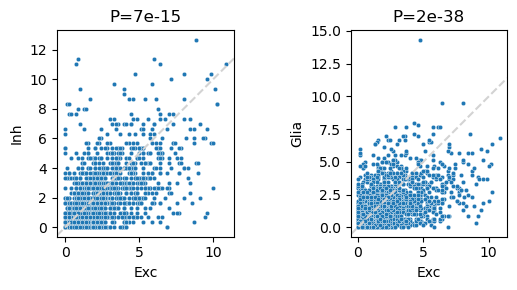

In [47]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    df = df_test.groupby(['gene_id', 'major_cell_type'], observed=True).enhancer_count.mean().unstack()
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for ax, cell_type in zip(axes.flat, ['Inh', 'Glia']):
        mask = slice(None)
        # mask = df[['Exc', cell_type]].ne(0).all(1)
        sns.scatterplot(ax=ax, x='Exc', y=cell_type, s=10, data=df.loc[mask])
        ax.axline((0, 0), slope=1, linestyle='--', color='lightgrey')
        # ax.axline(((df['Exc']-df[cell_type]).mean(), 0), slope=1, linestyle='--', color='C0')
        stat, pval = ttest_rel(df.loc[mask, 'Exc'], df.loc[mask, cell_type], alternative='greater')
        ax.set(title=f'P={pval:.0e}')
        ax.set_aspect('equal')
        # ax.set(xscale='log', yscale='log')
    fig.tight_layout()
    plt.show()
    plt.close('all')

/work/magroup/tianming/Researches/seqhic2expr/figures-gage-seq-mBC/gradient_nenhancer_majortype_scatter.pdf


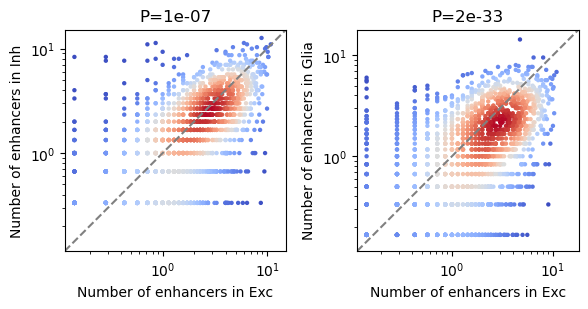

In [53]:
df_all = df_test.groupby(['gene_id', 'major_cell_type'], observed=True).enhancer_count.mean().unstack().fillna(0)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=False, sharey=False)
    for ax, cell_type in zip(axes.flat, ['Inh', 'Glia']):
        df = df_all.copy()
        # df += 1
        df = df[df[['Exc', cell_type]].ne(0).all(1)]
        x = df[['Exc', cell_type]].values
        x = np.log(x)
        density = KernelDensity(bandwidth=.3).fit(x).score_samples(x)
        density = np.exp(density)
        sns.scatterplot(
            ax=ax, x='Exc', y=cell_type, s=10, data=df,
            hue=density, palette='coolwarm', edgecolor='none')
        ax.get_legend().remove()
        ax.axline((0, 0), (1, 1), linestyle='--', color='grey')
        # ax.axline(((df['Exc']-df[cell_type]).mean(), 0), slope=1, linestyle='--', color='C0')
        stat, pval = ttest_rel(df['Exc'], df[cell_type], alternative='greater')
        ax.set(title=f'P={pval:.0e}')
        ax.set_aspect('equal', 'box')
        ax.set(xscale='log', yscale='log')
        lim = min(min(ax.get_xlim()), min(ax.get_ylim())), max(max(ax.get_xlim()), max(ax.get_ylim()))
        ax.set(xlim=lim, ylim=lim)
        ax.set(
            xlabel=f'Number of enhancers in {ax.get_xlabel()}',
            ylabel=f'Number of enhancers in {ax.get_ylabel()}',
        )
    fig.tight_layout()
    path2file = path2figdir / f"gradient_nenhancer_majortype_scatter.pdf"
    print(path2file)
    plt.savefig(path2file, dpi=600)
    plt.show()
    plt.close('all')

,major_cell_type,enhancer_count,has_enhancer
0,Exc,3.205764,0.349924
1,Inh,2.895929,0.330570
2,Glia,2.864678,0.289795


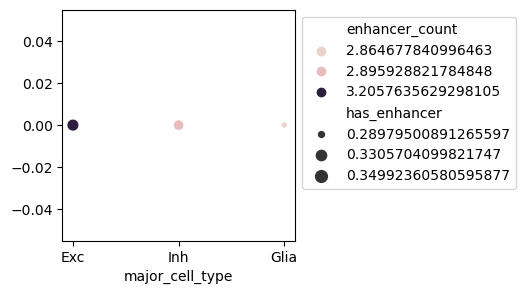

In [52]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    df = df_test.groupby(['major_cell_type']).agg(
        enhancer_count=pd.NamedAgg(column='enhancer_count', aggfunc="mean"),
        has_enhancer=pd.NamedAgg(column='has_enhancer', aggfunc="mean"),
    )
    df.enhancer_count /= df.has_enhancer
    df = df.reset_index()
    df = df[df.major_cell_type.ne('Unk')]
    display(df)
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.scatterplot(
        ax=ax, data=df, x='major_cell_type', y=np.zeros(len(df)), hue='enhancer_count', size='has_enhancer')
    sns.move_legend(ax, bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()
    plt.close('all')

# Comparison of CREs among DEGs

In [51]:
def fn(df_deg, df_cre, avg_log2fc_thr, p_val_thr=1e-3, cell_type_name=None, cre_name=None):
    df = df_deg
    df = df[df.p_val_adj.le(p_val_thr)]
    df = df[df.avg_log2FC.abs().ge(np.abs(avg_log2fc_thr))]
    df = df[df.avg_log2FC.apply(np.sign).eq(np.sign(avg_log2fc_thr))]
    df_deg = df
    df = df_cre
    df = df[df.gene_id.isin(df_deg.gene_id)]
    df = df.groupby('gene_id').size()
    df_cre = df
    df = pd.DataFrame(data={'cell_type': cell_type_name, 'cre_dataset': cre_name}, index=df_deg.gene_id)
    df['cre_count'] = df_cre
    df.cre_count.fillna(0, inplace=True)
    df['has_cre'] = df.cre_count > 0
    print(len(df_deg), df_cre.index.nunique(), len(df))
    return df

p_val_thr = 1e-3
df = pd.concat([
    fn(df_deg_dict['Exc-Inh'], df_cre_xie, .1, p_val_thr, 'Exc', 'Xie'),
    fn(df_deg_dict['Exc-Inh'], df_cre_xie, -.1, p_val_thr, 'Inh', 'Xie'),
    fn(df_deg_dict['Neu-Glia'], df_cre_xie, -.1, p_val_thr, 'Glia', 'Xie'),
    fn(df_deg_dict['Exc-Inh'], df_cre_pairedseq, .1, p_val_thr, 'Exc', 'Paired-Seq'),
    fn(df_deg_dict['Exc-Inh'], df_cre_pairedseq, -.1, p_val_thr, 'Inh', 'Paired-Seq'),
    fn(df_deg_dict['Neu-Glia'], df_cre_pairedseq, -.1, p_val_thr, 'Glia', 'Paired-Seq'),
])
df.cre_dataset = pd.Categorical(df.cre_dataset, categories=df.cre_dataset.unique())
df.cell_type = pd.Categorical(df.cell_type, categories=df.cell_type.unique())
df_test = df
del df

1123 458 1123
697 172 697
3941 482 3941
1123 540 1123
697 220 697
3941 1581 3941


In [52]:
for cre_dataset, df in df_test.groupby('cre_dataset'):
    print(mannwhitneyu(
        df[df.cell_type.eq('Exc')].cre_count, df[df.cell_type.eq('Inh')].cre_count, alternative='greater'))
    print(mannwhitneyu(
        df[df.cell_type.eq('Exc')].cre_count, df[df.cell_type.eq('Glia')].cre_count, alternative='greater'))

MannwhitneyuResult(statistic=464500.5, pvalue=1.270450960604625e-15)
MannwhitneyuResult(statistic=2872607.5, pvalue=1.526356091717259e-112)
MannwhitneyuResult(statistic=475711.5, pvalue=2.675964695914791e-18)
MannwhitneyuResult(statistic=2483263.0, pvalue=1.4210500458168708e-12)


/tmp/ipykernel_93422/2277194570.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cre_dataset, df in df_test.groupby('cre_dataset'):


,cell_type,cre_dataset,cre_count,has_cre
0,Exc,Xie,5.790393,0.407836
1,Exc,Paired-Seq,8.662963,0.480855
2,Inh,Xie,4.348837,0.246772
3,Inh,Paired-Seq,5.063636,0.315638
4,Glia,Xie,3.819502,0.122304
5,Glia,Paired-Seq,6.017078,0.401167


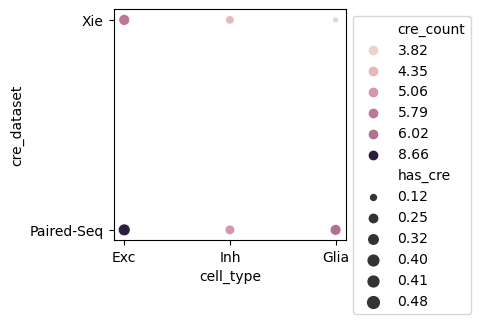

In [53]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    df = df_test.groupby(['cell_type', 'cre_dataset']).agg(
        cre_count=pd.NamedAgg(column='cre_count', aggfunc="mean"),
        has_cre=pd.NamedAgg(column='has_cre', aggfunc="mean"),
    )
    df.cre_count /= df.has_cre
    df = df.reset_index()
    display(df)
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.scatterplot(
        ax=ax, data=df, x='cell_type', y='cre_dataset', hue='cre_count', size='has_cre')
    sns.move_legend(ax, bbox_to_anchor=(1, 1), loc='upper left')
    for t in ax.get_legend().texts:
        if t._text[0].isdigit():
            t._text = f'{float(t._text):.2f}'
    plt.show()
    plt.close('all')

# Comparison of TF binding sites among DEGs

not significant

In [38]:
def fn(df_deg, df_tfbs, avg_log2fc_thr, p_val_thr=1e-3, cell_type_name=None):
    df = df_deg
    df = df[df.p_val_adj.le(p_val_thr)]
    df = df[df.avg_log2FC.abs().ge(np.abs(avg_log2fc_thr))]
    df = df[df.avg_log2FC.apply(np.sign).eq(np.sign(avg_log2fc_thr))]
    df_deg = df
    df = df_tfbs
    df = df[df.gene_id.isin(df_deg.gene_id)]
    # df = df.groupby('gene_id').hit.sum()
    df = df.groupby('gene_id').size()
    df_tfbs = df
    df = pd.DataFrame(data={'cell_type': cell_type_name, 'tf_dataset': 'all'}, index=df_deg.gene_id)
    df['tfbs_count'] = df_tfbs
    df.tfbs_count.fillna(0, inplace=True)
    df['has_tfbs'] = df.tfbs_count > 0
    print(len(df_deg), df.tfbs_count.mean(), df.has_tfbs.mean())
    return df

p_val_thr = 1e-3
df = pd.concat([
    fn(df_deg_dict['Exc-Inh'], df_tfbs_gene, .1, p_val_thr, 'Exc'),
    fn(df_deg_dict['Exc-Inh'], df_tfbs_gene, -.1, p_val_thr, 'Inh'),
    fn(df_deg_dict['Neu-Glia'], df_tfbs_gene, -.1, p_val_thr, 'Glia'),
])
df.tf_dataset = pd.Categorical(df.tf_dataset, categories=df.tf_dataset.unique())
df.cell_type = pd.Categorical(df.cell_type, categories=df.cell_type.unique())
df_test = df
del df

1123 19.258236865538734 0.10774710596616206
697 72.09469153515064 0.40746054519368724
3941 99.2760720629282 0.5612788632326821


In [39]:
for cre_dataset, df in df_test.groupby('tf_dataset'):
    print(mannwhitneyu(
        df[df.cell_type.eq('Exc')].tfbs_count, df[df.cell_type.eq('Inh')].tfbs_count, alternative='greater'))
    print(mannwhitneyu(
        df[df.cell_type.eq('Exc')].tfbs_count, df[df.cell_type.eq('Glia')].tfbs_count, alternative='greater'))

MannwhitneyuResult(statistic=275652.0, pvalue=1.0)
MannwhitneyuResult(statistic=1221129.5, pvalue=1.0)


/tmp/ipykernel_35993/3333137671.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cre_dataset, df in df_test.groupby('tf_dataset'):


# Example: genebody score is important in glial types

In [60]:
list(cell_type_color_map.keys())

['L2 IT RvPP',
 'L2/3 IT RSP',
 'L2/3 IT CTX a',
 'L2/3 IT CTX b',
 'L2/3 IT CTX c',
 'L4 IT CTX',
 'L4/5 IT CTX',
 'L5 IT RSP',
 'L5 IT CTX',
 'L6 IT CTX',
 'L5 PT CTX',
 'L6 CT CTX a',
 'L6 CT CTX b',
 'L5/6 NP CTX',
 'L6b CTX',
 'Pvalb a',
 'Pvalb b',
 'Sst a',
 'Sst b',
 'Vip',
 'Sncg',
 'Lamp5',
 'Meis2',
 'Astro',
 'OPC',
 'ODC',
 'VLMC',
 'Micro',
 'Unk']

In [54]:
df_grad

,gene_id,cell_type,feat_name,grad,grad_normalized
0,ENSMUSG00000000001,Astro,Seq,0.002762,0.184869
1,ENSMUSG00000000001,Astro,A/B,0.128784,0.206088
2,ENSMUSG00000000001,Astro,Insulation score,0.049286,0.159237
3,ENSMUSG00000000001,Astro,Genebody score,0.091553,0.134695
4,ENSMUSG00000000127,Astro,Seq,0.000345,0.023109
...,...,...,...,...,...
418875,ENSMUSG00000118518,Vip,Genebody score,0.093323,0.190508
418876,ENSMUSG00000118559,Vip,Seq,0.001171,0.108770
418877,ENSMUSG00000118559,Vip,A/B,0.049805,0.110587
418878,ENSMUSG00000118559,Vip,Insulation score,0.022324,0.100076


In [71]:
thr = 1.25
df = df_grad.copy()
df = df[df.feat_name.eq('Genebody score')].pivot(index='gene_id', columns='cell_type', values='grad_normalized')
cell_type_1 = ['Astro']
cell_type_2 = [_ for _ in df.columns if _.startswith('L')]
cell_type_3 = ['Pvalb a', 'Pvalb b', 'Sst a', 'Sst b', 'Vip', 'Sncg', 'Lamp5', 'Meis2']
mask_gb = (df[cell_type_1].mean(1) / df[cell_type_2].mean(1) > thr) & \
    (df[cell_type_1].mean(1) / df[cell_type_3].mean(1) > thr)
print('gb', mask_gb.sum(), mask_gb.mean())

df = df_grad.copy()
df = df[df.feat_name.eq('Seq')].pivot(index='gene_id', columns='cell_type', values='grad_normalized')
cell_type_1 = ['Astro']
cell_type_2 = [_ for _ in df.columns if _.startswith('L')]
cell_type_3 = ['Pvalb a', 'Pvalb b', 'Sst a', 'Sst b', 'Vip', 'Sncg', 'Lamp5', 'Meis2']
mask_seq = (df[cell_type_1].mean(1) / df[cell_type_2].mean(1) < 1/thr) & \
    (df[cell_type_1].mean(1) / df[cell_type_3].mean(1) < 1/thr)
print('seq', mask_seq.sum(), mask_seq.mean())

mask = mask_gb & mask_seq
print('all', mask.sum(), mask.mean())
print(mask[mask])

gb 730 0.19518716577540107
seq 1792 0.47914438502673795
all 3 0.0008021390374331551
gene_id
ENSMUSG00000001248    True
ENSMUSG00000034903    True
ENSMUSG00000074024    True
dtype: bool


In [ ]:
genes = mask[mask].index.values
